# Coordination failure in Cooperative Offline MARL: Policy Gradient Methods with Polygames
### Neural Information Processing Systems, May 2024
Anon authors

**Notebook usage** \\
Note that cells of this notebook necessarily need to be run in order, as some functions are overwritten during the course of the notebook. Additionally, all experiments accept q_fn as input, meaning that all experiments should in theory be able to be run on any of the polynomials (or indeed, any given polynomial). However, this is largely untested, and the current visualisations are tailored to the experiments at hand, and so interpretable results are not guaranteed.

In [118]:
#@title Import necessary libraries

# special imports
try:
  import flashbax as fbx
except:
  !pip install flashbax
  import flashbax as fbx

# modules available in collab
import flax.linen as nn
import jax
import jax.numpy as jnp
from typing import Tuple, Callable, Optional, List, Dict
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from functools import partial
import optax
import plotly.graph_objs as go
import plotly.io as pio
from pathlib import Path
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import copy
from flashbax.buffers import sum_tree
import matplotlib.animation as animation
import pickle
import time

# Preliminaries

## What does a polygame look like in MARL
In a polynomial game, an agent's action is to choose a value which is used as input to a polynomial. The output of the polynomial is used as the shared reward received by the agents. \
Let us demonstrate this using two agents $x$ and $y$, and the simple polynomial $f(x,y)=xy$.

In [119]:
# @title Plotting utilities (run before the next cell)
def plot_surface(surface_fn: Callable):
    domain = jnp.linspace(-1, 1, 1000)
    plt.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1))
    # plt.clim(-1, 1)
    plt.colorbar().set_label('Reward')

    plt.xlabel('Action x')
    plt.ylabel('Action y')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    plt.gcf().set_size_inches(5,4)
    plt.title("Reward function surface")

def interact_plot(x,y,surface_fn):
  # using a closure to define the interactive function flexibly
  @interact(x=(-1,1,0.1),y=(-1,1,0.1))
  def plot_point_on_surface(x,y):
    plot_surface(surface_fn)

    plt.scatter(x,y,c="black")
    plt.text(x-0.3,y+0.05,"Reward: %.2f" % surface_fn(x,y))
    plt.show()

In [120]:
# define a polynomial reward function
@jax.jit
def q_fn(x, y):
    return x * y

# visualise the function
interact_plot(0,1,q_fn)

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0), FloatSlider(value=0.0, descr…

## Online MADDPG solves a polygame
MADDPG calculates a policy update based on data sampled from a replay buffer $B$. Each agent $a_i$ chooses its action as follows:
$$\mathbf{a}_i = (\mu(o_i;\theta_i),a_{-i} \sim B),$$
where $\mu$ is the agent's policy and $a_{-i}$ is an action of another agent, sampled from the replay buffer.

The formulation of a policy gradient method is simple for polygames: the gradient of the policy is in fact the gradient of the reward function polynomial. \\
Suppose we have two agents, one taking action $x$ and the other taking action $y$. Then:
$$ \nabla_{\theta_x} J = \nabla_{\theta_x} \theta_x \cdot \nabla_{a_x} R(a_x, \hat{a}_y) |_{a_x = \mu(s_0; \theta_x), \; \hat{a}_y \sim \mathcal{B}} $$
$$= \nabla_{x} R(a_x, \hat{a}_y) |_{\hat{a}_y \sim \mathcal{B}}$$

In [121]:
# @title Policy definition and online MADDPG algorithm (run before next cell)

class Policy(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(1)(x)
        return x

s0 = jnp.zeros(shape=(2))  # Env is stateless, so we just use a dummy state
actor = Policy()

def make_policy(key: jnp.ndarray, policy_init: Tuple[float, float]) -> Tuple[nn.Module, nn.Module]:
    x_params = actor.init(key, s0)
    y_params = actor.init(key, s0)

    x_params = jax.tree.map(lambda x: jnp.zeros_like(x), x_params)
    y_params = jax.tree.map(lambda x: jnp.zeros_like(x), y_params)

    x_params["params"]["Dense_0"]["bias"] = x_params["params"]["Dense_0"]["bias"].at[0].set(policy_init[0])
    y_params["params"]["Dense_0"]["bias"] = y_params["params"]["Dense_0"]["bias"].at[0].set(policy_init[1])

    return x_params, y_params

def online_maddpg(q_fn, seed=42, buffer_size=256, batch_size=32, epochs=80, burn_in_steps=32, explore_steps_per_epoch=16, explore_radius=0.1, lr=1e-1, policy_init=(-0.6,0.65)):

  key = jax.random.PRNGKey(seed)

  buffer = fbx.make_item_buffer(
      max_length=buffer_size,
      min_length=1,
      sample_batch_size=batch_size,
  )

  buffer_state = buffer.init({"x": jnp.array([0.0]), "y": jnp.array([0.0])})
  acts_history = jnp.zeros(shape=(epochs * explore_steps_per_epoch + burn_in_steps, 2))
  acts_history_counter = 0

  x_params, y_params = make_policy(key, policy_init)
  opt = optax.sgd(lr)
  x_opt_state = opt.init(x_params)
  y_opt_state = opt.init(y_params)

  # For plotting the joint policy trajectory
  joint_policy_trajectory = jnp.zeros(shape=(epochs+1, 2))

  # Add initial joint-policy
  joint_policy = jnp.concatenate([x_params["params"]["Dense_0"]["bias"], y_params["params"]["Dense_0"]["bias"]], axis=0)
  joint_policy_trajectory = joint_policy_trajectory.at[0].set(joint_policy)

  def exploration(key, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius):
      key, *action_keys = jax.random.split(key, 3)
      x_curr = actor.apply(x_params, s0) + jax.random.normal(action_keys[0], shape=(1,)) * explore_radius
      y_curr = actor.apply(y_params, s0) + jax.random.normal(action_keys[1], shape=(1,)) * explore_radius
      buffer_state = buffer.add(buffer_state, {"x": x_curr, "y": y_curr})
      acts_history = acts_history.at[acts_history_counter].set(jnp.concatenate([x_curr, y_curr], axis=0))
      acts_history_counter += 1
      return key, buffer_state, acts_history, acts_history_counter

  jit_exploration = jax.jit(exploration)

  def burn_in_exploration(key, burn_in_steps, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius):
      for i in range(burn_in_steps):
          key, buffer_state, acts_history, acts_history_counter = jit_exploration(key, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius)
      return buffer_state, acts_history, acts_history_counter

  def epoch_exploration(key, explore_steps_per_epoch, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius):
    for i in range(explore_steps_per_epoch):
      key, buffer_state, acts_history, acts_history_counter = jit_exploration(key, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius)
    return buffer_state, acts_history, acts_history_counter

  def train(key, x_params, y_params, x_opt_state, y_opt_state, buffer_state):
    def policy_x_loss(params_x, batch):
      act_x = actor.apply(params_x, s0)
      q_val = q_fn(act_x, batch[:, 1:2])
      return -jnp.mean(q_val), act_x

    def policy_y_loss(params_y, batch):
      act_y = actor.apply(params_y, s0)
      q_val = q_fn(batch[:, 0:1], act_y)
      return -jnp.mean(q_val), act_y

    batch_key, key = jax.random.split(key, 2)
    samples = buffer.sample(buffer_state, batch_key)
    batch = jnp.concatenate(jax.tree_util.tree_flatten(samples.experience)[0], axis=1)

    (loss_x, act_x), grad_x = jax.value_and_grad(policy_x_loss, has_aux=True)(x_params, batch)
    updates_x, x_opt_state = opt.update(grad_x, x_opt_state)
    x_params = optax.apply_updates(x_params, updates_x)

    (loss_y, act_y), grad_y = jax.value_and_grad(policy_y_loss, has_aux=True)(y_params, batch)
    updates_y, y_opt_state = opt.update(grad_y, y_opt_state)
    y_params = optax.apply_updates(y_params, updates_y)

    return x_params, y_params, x_opt_state, y_opt_state
  jit_train = jax.jit(train)


  # MAIN

  buffer_states_history = []
  # Add initial exploration data to replay buffer
  buffer_state, acts_history, acts_history_counter = burn_in_exploration(key, burn_in_steps, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius)

  for e in range(1, epochs+1):
    buffer_state, acts_history, acts_history_counter = epoch_exploration(key, explore_steps_per_epoch, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius)
    x_params, y_params, x_opt_state, y_opt_state = jit_train(key, x_params, y_params, x_opt_state, y_opt_state, buffer_state)
    key, _ = jax.random.split(key)

    # Add latest joint-policy
    joint_policy = jnp.concatenate([x_params["params"]["Dense_0"]["bias"], y_params["params"]["Dense_0"]["bias"]], axis=0)
    joint_policy_trajectory = joint_policy_trajectory.at[e].set(joint_policy)

    if True:
      buffer_states_history.append(
        jnp.stack(
          (
            buffer_state.experience["x"][0,:,0],
            buffer_state.experience["y"][0,:,0],
            q_fn(
              buffer_state.experience["x"][0,:,0],
              buffer_state.experience["y"][0,:,0],
            ),
          ),
          axis=1,
        )
      )

  return joint_policy_trajectory, acts_history, buffer_states_history

In [122]:
# @title Plotting utilities (run before the next cell)

# for plotting a trajectory against a surface function
def plot_surface_trajectory(surface_fn: Callable, trajectory: jnp.ndarray, ax, step: int = 1, title: Optional[str] = "trajectory"):
    domain = jnp.linspace(-1, 1, 1000)
    ax.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1))

    # Trajectory
    # Extract x and y coordinates
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Plot the trajectory
    ax.plot(x, y, '-w.', alpha=0.6)  # '-o' for lines with markers

    # Mark start and end points
    ax.plot(x[0], y[0], 'go')  # start point
    ax.text(x[0]-0.03,y[0]+0.05, 'start')
    ax.plot(x[-1], y[-1], 'ro')  # end point
    ax.text(x[-1]-0.03,y[-1]+0.05, 'end')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

def plot_sample_efficiency_curve(surface_fn: Callable, trajectory: jnp.ndarray, ax, epoch_lim, step: int = 1, title: Optional[str] = "trajectory"):
  # Trajectory
  # Extract x and y coordinates
  x = trajectory[0::step, 0]
  y = trajectory[0::step, 1]

  returns = surface_fn(x,y)

  # Plot the trajectory
  ax.plot(returns, '-b.', alpha=0.6)  # '-o' for lines with markers

  ax.set_ylim(-1, 1)
  ax.set_xlim(-2, epoch_lim+2)

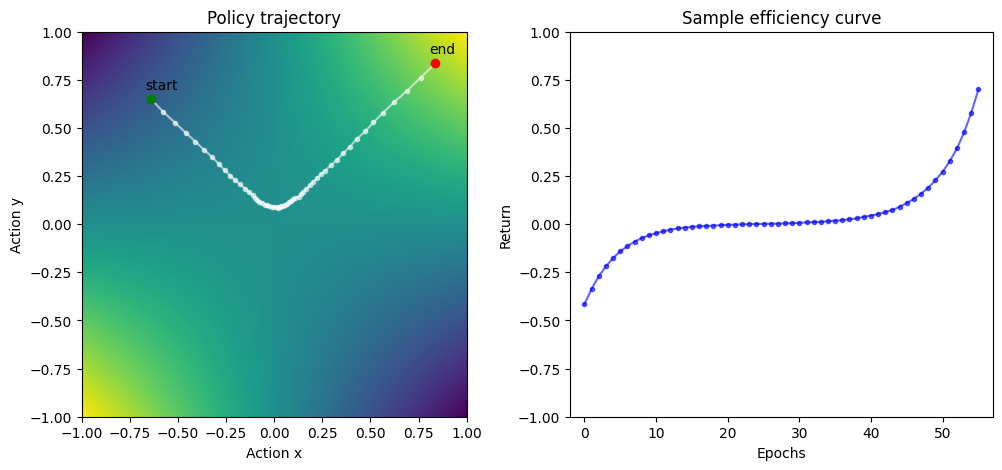

In [123]:
# Hyperparameters
rb_size = 32
lr = 1e-1
epochs = 55
policy_init = (-0.64, 0.65)

joint_policy_trajectory, acts_history, buffer_states_history = online_maddpg(
    q_fn,
    buffer_size=rb_size,
    lr=lr,
    policy_init=policy_init,
    epochs=epochs,
)

fig,ax = plt.subplots(1,2,figsize=(12,5))

# Plot trajectory
plot_surface_trajectory(q_fn, joint_policy_trajectory, ax[0], title=f"trajectory_{rb_size}")

ax[0].set_xlabel('Action x')
ax[0].set_ylabel('Action y')
ax[0].set_title("Policy trajectory")

plot_sample_efficiency_curve(q_fn, joint_policy_trajectory, ax[1],epochs)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Return")
ax[1].set_title("Sample efficiency curve")

plt.show()

## MADDPG in an increasingly off-policy setting
As we saw previously, MADDPG's performance is affected by its reliance on off-policy data. However, the gradient direction is automatically corrected by the algorithm's ability to interact with the environment based on an updated policy over time. \\
But what happens when our training data becomes increasingly out-of-date?
The following section is a primer for intuition surroundig how MADDPG acts when less and less of the data it uses is on-policy.

**Varying replay buffer size** \\
Replay buffers have been used to stabilise training in MARL. However, they add some level of off-policy-ness to the algorithm, since they learn from data that is not the most recently generated data available - and therefore was not generated from the current policy. \\


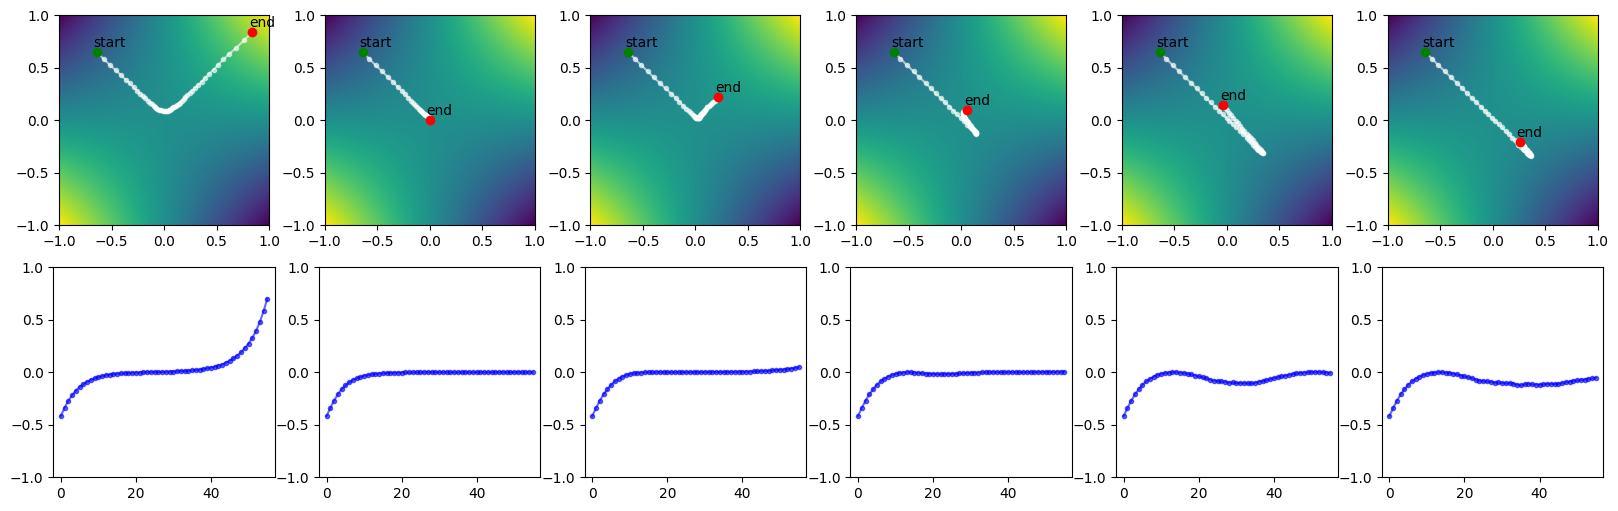

In [124]:
# Hyperparameters
rb_sizes = [32,64,128,256,512,1024]
fig,ax = plt.subplots(2,len(rb_sizes),figsize=(20,6))

for i, rb_size in enumerate(rb_sizes):

  joint_policy_trajectory, acts_history, buffer_states_history = online_maddpg(
      q_fn,
      buffer_size=rb_size,
      batch_size=32,
      lr=lr,
      policy_init=policy_init,
      epochs=epochs,
  )

  # Plot trajectory
  plot_surface_trajectory(q_fn, joint_policy_trajectory, ax[0,i], title=f"trajectory_{rb_size}")
  plot_sample_efficiency_curve(q_fn, joint_policy_trajectory, ax[1,i],epochs)
plt.show()

It is clear that a larger replay buffer size slows learning in this case. For a replay buffer size of $64$, we observe that the gradient happens to become quite flat, which may be the result of not having enough momentum upon reaching the saddle point of the reward function. \\
Let us give MADDPG the chance to learn as much as it can within the range we are interested in. To do so, we do not limit the number of epochs.

**Varying buffer size without limiting epochs**


In [125]:
# @title MADDPG with different limits
def online_maddpg_limit_policy(q_fn, seed=42, buffer_size=256, batch_size=32, epochs=80, burn_in_steps=32, explore_steps_per_epoch=16, explore_radius=0.1, lr=1e-1, policy_init=(-0.6,0.65)):

  key = jax.random.PRNGKey(seed)

  buffer = fbx.make_item_buffer(
      max_length=buffer_size,
      min_length=1,
      sample_batch_size=batch_size,
  )

  buffer_state = buffer.init({"x": jnp.array([0.0]), "y": jnp.array([0.0])})
  acts_history = jnp.zeros(shape=(epochs * explore_steps_per_epoch + burn_in_steps, 2))
  acts_history_counter = 0

  x_params, y_params = make_policy(key, policy_init)
  opt = optax.sgd(lr)
  x_opt_state = opt.init(x_params)
  y_opt_state = opt.init(y_params)

  # For plotting the joint policy trajectory
  joint_policy_trajectory = jnp.zeros(shape=(1000, 2))

  # Add initial joint-policy
  joint_policy = jnp.concatenate([x_params["params"]["Dense_0"]["bias"], y_params["params"]["Dense_0"]["bias"]], axis=0)
  joint_policy_trajectory = joint_policy_trajectory.at[0].set(joint_policy)

  def exploration(key, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius):
      key, *action_keys = jax.random.split(key, 3)
      x_curr = actor.apply(x_params, s0) + jax.random.normal(action_keys[0], shape=(1,)) * explore_radius
      y_curr = actor.apply(y_params, s0) + jax.random.normal(action_keys[1], shape=(1,)) * explore_radius
      buffer_state = buffer.add(buffer_state, {"x": x_curr, "y": y_curr})
      acts_history = acts_history.at[acts_history_counter].set(jnp.concatenate([x_curr, y_curr], axis=0))
      acts_history_counter += 1
      return key, buffer_state, acts_history, acts_history_counter

  jit_exploration = jax.jit(exploration)

  def burn_in_exploration(key, burn_in_steps, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius):
      for i in range(burn_in_steps):
          key, buffer_state, acts_history, acts_history_counter = jit_exploration(key, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius)
      return buffer_state, acts_history, acts_history_counter

  def epoch_exploration(key, explore_steps_per_epoch, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius):
    for i in range(explore_steps_per_epoch):
      key, buffer_state, acts_history, acts_history_counter = jit_exploration(key, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius)
    return buffer_state, acts_history, acts_history_counter

  def train(key, x_params, y_params, x_opt_state, y_opt_state, buffer_state):
    def policy_x_loss(params_x, batch):
      act_x = actor.apply(params_x, s0)
      q_val = q_fn(act_x, batch[:, 1:2])
      return -jnp.mean(q_val), act_x

    def policy_y_loss(params_y, batch):
      act_y = actor.apply(params_y, s0)
      q_val = q_fn(batch[:, 0:1], act_y)
      return -jnp.mean(q_val), act_y

    batch_key, key = jax.random.split(key, 2)
    samples = buffer.sample(buffer_state, batch_key)
    batch = jnp.concatenate(jax.tree_util.tree_flatten(samples.experience)[0], axis=1)

    (loss_x, act_x), grad_x = jax.value_and_grad(policy_x_loss, has_aux=True)(x_params, batch)
    updates_x, x_opt_state = opt.update(grad_x, x_opt_state)
    x_params = optax.apply_updates(x_params, updates_x)

    (loss_y, act_y), grad_y = jax.value_and_grad(policy_y_loss, has_aux=True)(y_params, batch)
    updates_y, y_opt_state = opt.update(grad_y, y_opt_state)
    y_params = optax.apply_updates(y_params, updates_y)

    return x_params, y_params, x_opt_state, y_opt_state, samples
  jit_train = jax.jit(train)


  # MAIN

  buffer_states_history = []
  samples_list = []
  # Add initial exploration data to replay buffer
  buffer_state, acts_history, acts_history_counter = burn_in_exploration(key, burn_in_steps, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius)

  e = 1

  while jnp.max(jnp.abs(joint_policy))<1:
    buffer_state, acts_history, acts_history_counter = epoch_exploration(key, explore_steps_per_epoch, buffer_state, acts_history, acts_history_counter, x_params, y_params, explore_radius)
    x_params, y_params, x_opt_state, y_opt_state, samples = jit_train(key, x_params, y_params, x_opt_state, y_opt_state, buffer_state)
    key, _ = jax.random.split(key)

    # Add latest joint-policy
    joint_policy = jnp.concatenate([x_params["params"]["Dense_0"]["bias"], y_params["params"]["Dense_0"]["bias"]], axis=0)
    joint_policy_trajectory = joint_policy_trajectory.at[e].set(joint_policy)
    e+=1

    samples_list.append(samples)

    if buffer_state.is_full:
      index = -1
    else:
      index = buffer_state.current_index

    if True:
      buffer_states_history.append(
        jnp.stack(
          (
            buffer_state.experience["x"][0,:index,0],
            buffer_state.experience["y"][0,:index,0],
            jnp.ones_like(buffer_state.experience["y"][0,:index,0])*buffer_state.current_index,
            q_fn(
              buffer_state.experience["x"][0,:index,0],
              buffer_state.experience["y"][0,:index,0],
            ),
          ),
          axis=1,
        )
      )

  return joint_policy_trajectory, acts_history, buffer_states_history, e, samples_list

In [126]:
# @title Plotting utilities

def plot_rb_with_samples(ax,samples,buffer_state,epochs,alpha):
  buffer_index = buffer_state[0,2]
  # get the age of samples
  buffer_state_oldness = np.arange(buffer_state.shape[0])
  buffer_state_oldness = np.flip(buffer_state_oldness)
  buffer_state_oldness = np.floor_divide(buffer_state_oldness+16,16)
  buffer_state_oldness = np.roll(buffer_state_oldness,shift=int(buffer_index))

  ax.scatter(buffer_state[:,0],buffer_state[:,1],c=buffer_state_oldness,alpha=alpha,cmap='inferno_r',vmin=-5,vmax = 58)
  ax.scatter(samples['x'],samples['y'], facecolors='none', edgecolors='r',alpha=alpha)
  ax.set_xlim(-1,1)
  ax.set_ylim(-1,1)

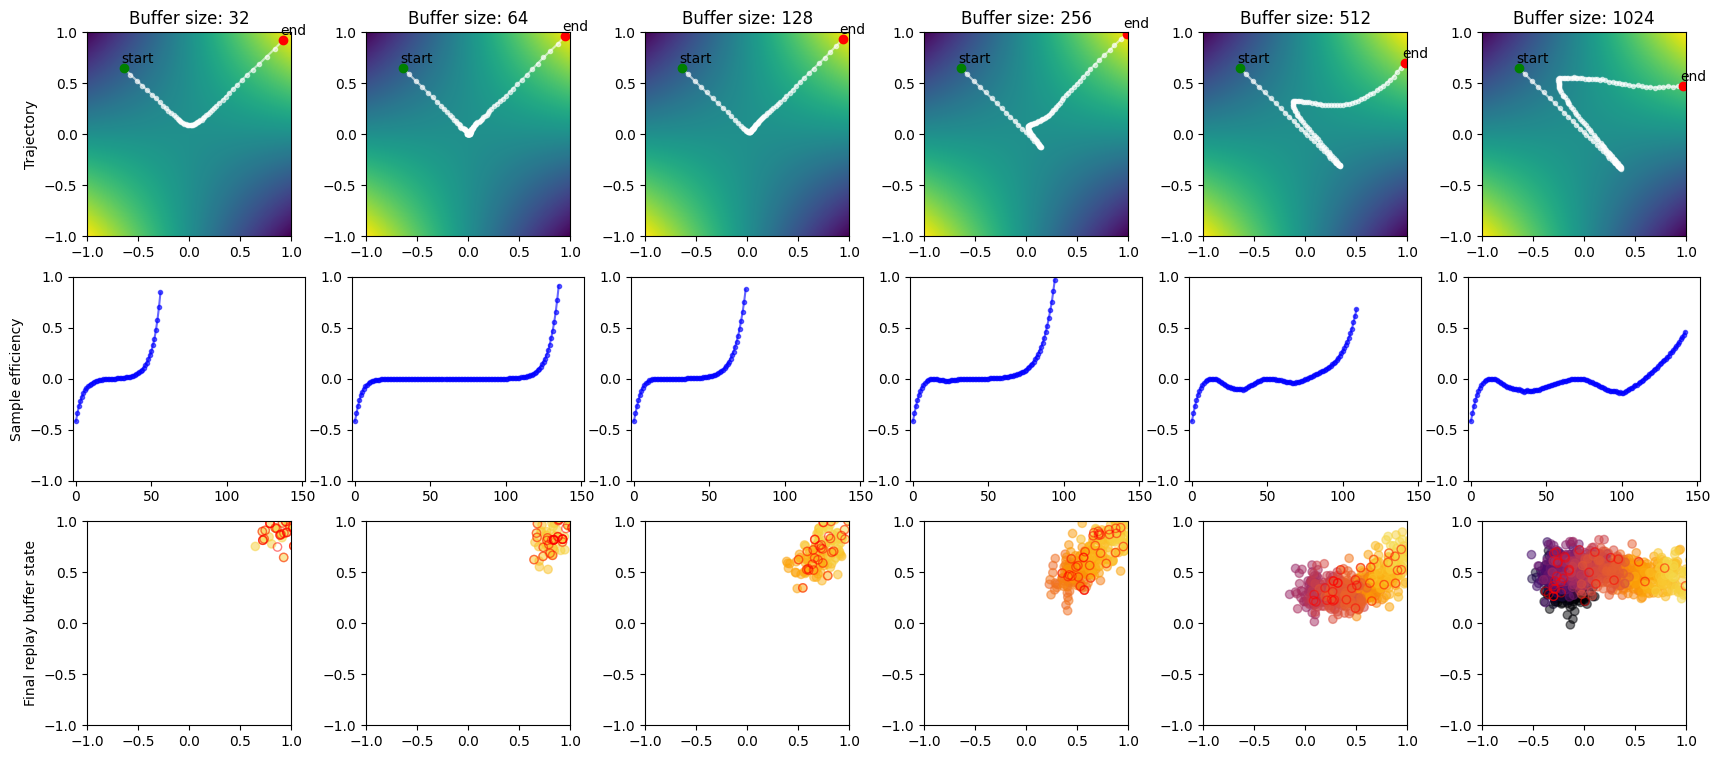

In [127]:
# Hyperparameters
rb_sizes = [32,64,128,256,512,1024]
fig,ax = plt.subplots(3,len(rb_sizes),figsize=(3.5*len(rb_sizes),9))

samples_dict = {}
buffer_states_history_dict = {}
num_epochs = {}

for i, rb_size in enumerate(rb_sizes):

  joint_policy_trajectory, acts_history, buffer_states_history, epoch_num, samples_list = online_maddpg_limit_policy(
      q_fn,
      buffer_size=rb_size,
      batch_size=32,
      lr=lr,
      policy_init=policy_init,
      epochs=epochs,
  )

  samples_dict[str(rb_size)] = samples_list
  buffer_states_history_dict[str(rb_size)] = buffer_states_history
  num_epochs[str(rb_size)] = epoch_num

  # Plot trajectory
  plot_surface_trajectory(q_fn, joint_policy_trajectory[:epoch_num-1,:], ax[0,i], title=f"trajectory_{rb_size}")
  plot_sample_efficiency_curve(q_fn, joint_policy_trajectory[:epoch_num-1,:], ax[1,i],150)
  plot_rb_with_samples(ax[2,i],samples_list[-1].experience, buffer_states_history[-1], epoch_num,alpha = 0.5)

  # sm = plt.cm.ScalarMappable(cmap="inferno_r",norm=matplotlib.colors.Normalize(vmin=-5, vmax=58))
  # fig.colorbar(sm, cax=cbar_ax)

  ax[2,i].set_aspect('equal')

  ax[0,i].set_title("Buffer size: "+str(rb_size))
ax[0,0].set_ylabel("Trajectory")
ax[1,0].set_ylabel("Sample efficiency")
ax[2,0].set_ylabel("Final replay buffer state")
plt.savefig("off-policy-plot.pdf",format="pdf")
plt.show()

MADDPG appears to struggle when we increase buffer size - this implies that the algorithm performance may depend on how on-policy the data is upon which it learns.
Below we can see the agility with which MADDPG adapts to updating policies given a specific replay buffer size.

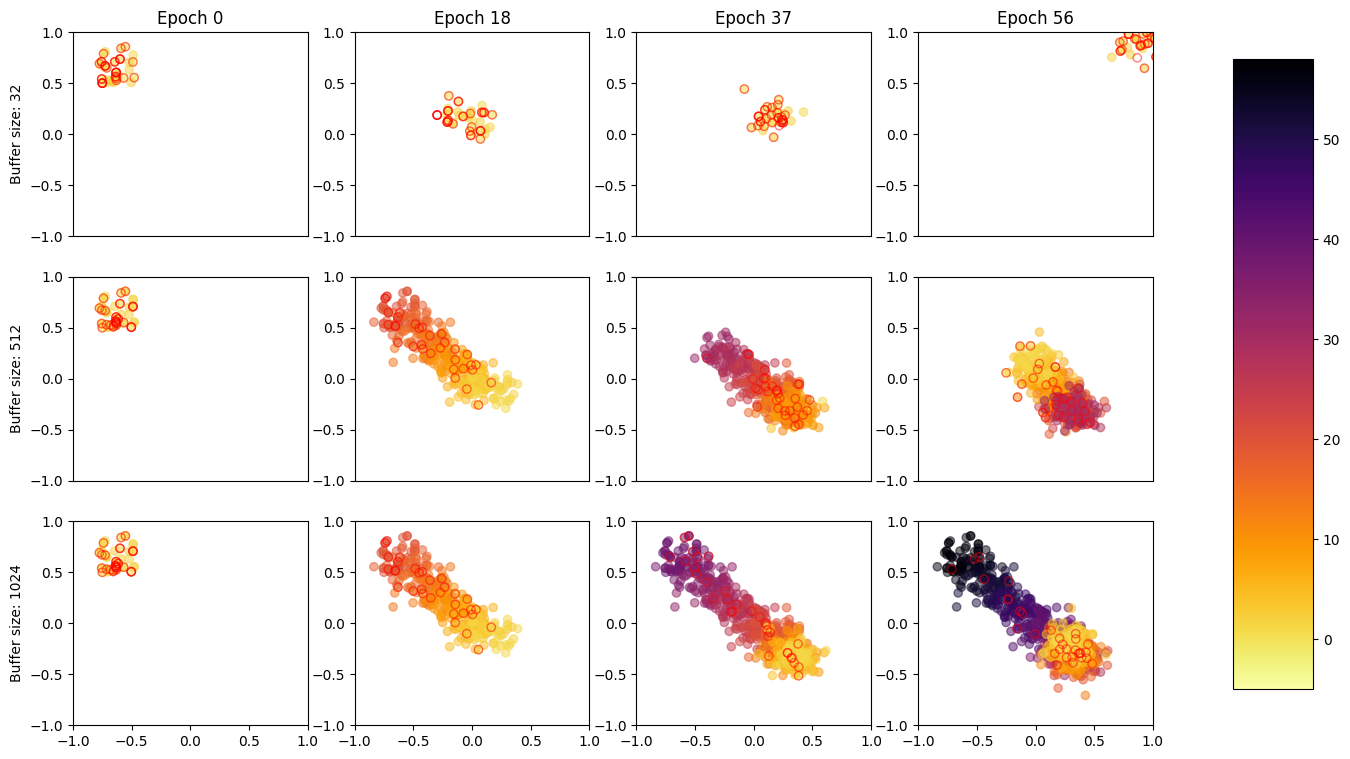

In [128]:
# plot for specific replay buffer sizes, and slice evenly during training
rb_sizes = [32,512,1024]
slices = 4
fig,ax = plt.subplots(len(rb_sizes),slices,figsize=(4*slices,3*len(rb_sizes)))

slice_vals = [int((num_epochs[str(32)]-2)/(slices-1)*j) for j in range(slices)]


for i,rb_size in enumerate(rb_sizes):
  samples_list = samples_dict[str(rb_size)]
  buffer_states_history = buffer_states_history_dict[str(rb_size)]
  epochs = num_epochs[str(rb_size)]
  ax[i,0].set_ylabel("Buffer size: "+str(rb_size))

  for j,k in enumerate(slice_vals):
    plot_rb_with_samples(ax[i,j],samples_list[k].experience,buffer_states_history[k],epochs,alpha=0.5)
    if i==0:
      ax[i,j].set_title("Epoch "+str(k))
    if i!=(len(rb_sizes)-1):
      ax[i,j].tick_params(axis='x', which='both',bottom=False,top=False,labelbottom=False)
# https://stackoverflow.com/questions/8342549/add-colorbar-to-a-sequence-of-line-plots
sm = plt.cm.ScalarMappable(cmap="inferno_r",norm=matplotlib.colors.Normalize(vmin=-5, vmax=58))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sm, cax=cbar_ax)
plt.show()

### **Exact code used to generate figures in the paper**

In [129]:
# @title Plotting utilities (run before the next cell)

# for plotting a trajectory against a surface function
def plot_surface_trajectory(surface_fn: Callable, trajectory: jnp.ndarray, ax, step: int = 1, title: Optional[str] = "trajectory"):
    domain = jnp.linspace(-1, 1, 1000)
    ax.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1))

    # Trajectory
    # Extract x and y coordinates
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Plot the trajectory
    ax.plot(x, y, '-w.', alpha=0.6)  # '-o' for lines with markers

    # Mark start and end points
    label1, = ax.plot(x[0], y[0], 'go',label="start")  # start point
    label2, = ax.plot(x[-1], y[-1], 'ro',label="end")  # end point

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel("Action x")

    return label1, label2

def plot_sample_efficiency_curve(surface_fn: Callable, trajectory: jnp.ndarray, ax, epoch_lim, step: int = 1, title: Optional[str] = "trajectory"):
  # Trajectory
  # Extract x and y coordinates
  x = trajectory[0::step, 0]
  y = trajectory[0::step, 1]

  returns = surface_fn(x,y)

  # Plot the trajectory
  ax.plot(returns, '-b.', alpha=0.6)  # '-o' for lines with markers

  ax.set_ylim(-0.5, 1)
  ax.set_xlim(-2, epoch_lim+2)
  ax.set_xlabel("epochs")

# @title Plotting utilities

def plot_rb_with_samples(ax,samples,buffer_state,epochs,alpha):
  buffer_index = buffer_state[0,2]
  # get the age of samples
  buffer_state_oldness = np.arange(buffer_state.shape[0])
  buffer_state_oldness = np.flip(buffer_state_oldness)
  buffer_state_oldness = np.floor_divide(buffer_state_oldness+16,16)
  buffer_state_oldness = np.roll(buffer_state_oldness,shift=int(buffer_index))

  ax.scatter(buffer_state[:,0],buffer_state[:,1],c=buffer_state_oldness,alpha=alpha,cmap='inferno_r',vmin=-5,vmax = 58)
  ax.scatter(samples['x'],samples['y'], facecolors='none', edgecolors='r',alpha=alpha,label="samples chosen for training")
  ax.set_xlim(-1,1)
  ax.set_ylim(-1,1)

  ax.set_xlabel("Action x")

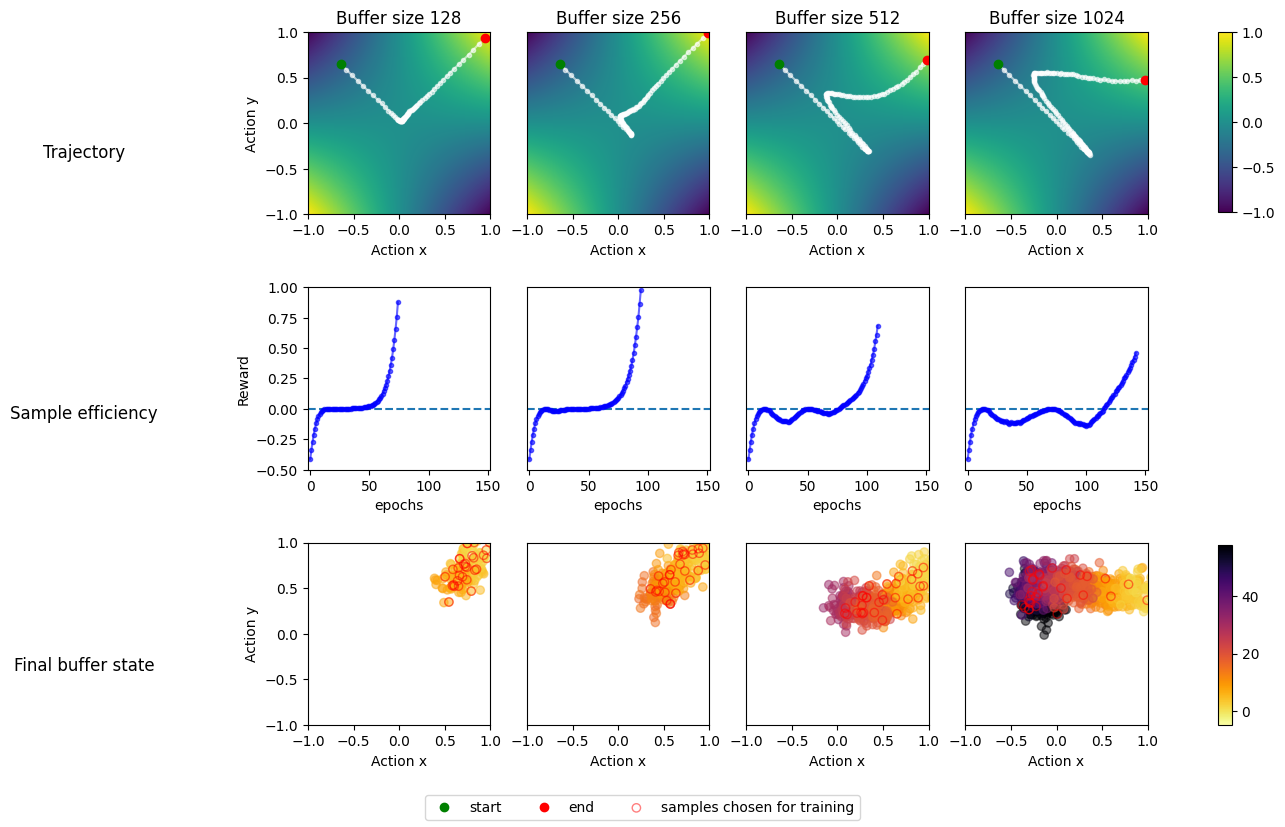

In [130]:
plt.rcParams["font.family"] = "sans-serif"

# Hyperparameters
rb_sizes = [128,256,512,1024]

# lr = 1e-1
# epochs = 55
# policy_init = (-0.64, 0.65)
fig,ax = plt.subplots(3,len(rb_sizes),figsize=(3.5*len(rb_sizes),9))

samples_dict = {}
buffer_states_history_dict = {}
num_epochs = {}

for i, rb_size in enumerate(rb_sizes):

  joint_policy_trajectory, acts_history, buffer_states_history, epoch_num, samples_list = online_maddpg_limit_policy(
      q_fn,
      buffer_size=rb_size,
      batch_size=32,
      lr=lr,
      policy_init=policy_init,
      epochs=epochs,
  )

  samples_dict[str(rb_size)] = samples_list
  buffer_states_history_dict[str(rb_size)] = buffer_states_history
  num_epochs[str(rb_size)] = epoch_num


  ax[1,i].axhline(0, linestyle='--')

  # Plot trajectory
  plot_surface_trajectory(q_fn, joint_policy_trajectory[:epoch_num-1,:], ax[0,i], title=f"trajectory_{rb_size}")
  plot_sample_efficiency_curve(q_fn, joint_policy_trajectory[:epoch_num-1,:], ax[1,i],150)
  plot_rb_with_samples(ax[2,i],samples_list[-1].experience, buffer_states_history[-1], epoch_num,alpha = 0.5)

  # sm = plt.cm.ScalarMappable(cmap="inferno_r",norm=matplotlib.colors.Normalize(vmin=-5, vmax=58))
  # fig.colorbar(sm, cax=cbar_ax)
  if i!=0:
    for j in range(3):
      ax[j,i].set_yticks([])

  ax[2,i].set_aspect('equal')

  ax[0,i].set_title("Buffer size "+str(rb_size))


ax[0,0].set_ylabel("Action y")
ax[1,0].set_ylabel("Reward")
ax[2,0].set_ylabel("Action y")

fig.subplots_adjust(hspace=0.4)#,wspace=0.3)

fig.subplots_adjust(left=0.2)
fig.text(0.04, 0.74, 'Trajectory', ha='center',fontsize=12)
fig.text(0.04, 0.45, 'Sample efficiency', ha='center',fontsize=12)
fig.text(0.04, 0.17, 'Final buffer state', ha='center',fontsize=12)
# fig.text(0.5, 0.92, 'Trajectory', ha='center',fontsize=14)
# fig.text(0.5, 0.61, 'Sample efficiency', ha='center',fontsize=14)
# fig.text(0.5, 0.33, 'Final buffer state', ha='center',fontsize=14)

inferno_sm = plt.cm.ScalarMappable(cmap="inferno_r",norm=matplotlib.colors.Normalize(vmin=-5, vmax=58))
viridis_sm = plt.cm.ScalarMappable(cmap="viridis",norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.11, 0.01, 0.2])
fig.colorbar(inferno_sm, cax=cbar_ax)

cbar_ax2 = fig.add_axes([0.85, 0.68, 0.01, 0.2])
fig.colorbar(viridis_sm, cax=cbar_ax2)


lines_labels = [ax.get_legend_handles_labels() for ax in [ax[0,0],ax[2,0]]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,ncols=3,loc='lower center')


fig.savefig("off-policy-plot.pdf",format="pdf",bbox_inches='tight')
plt.show()

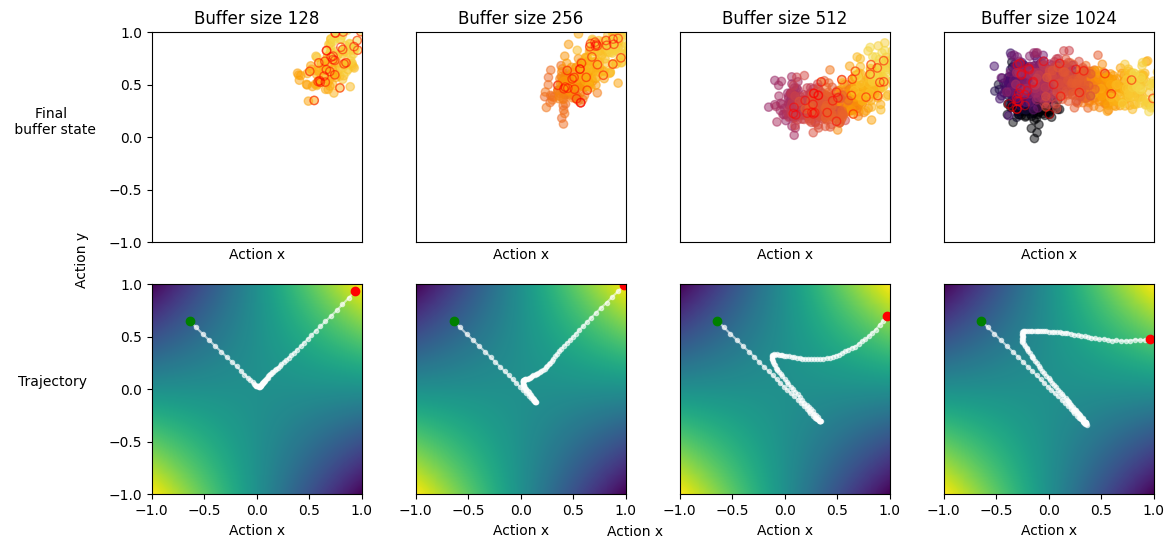

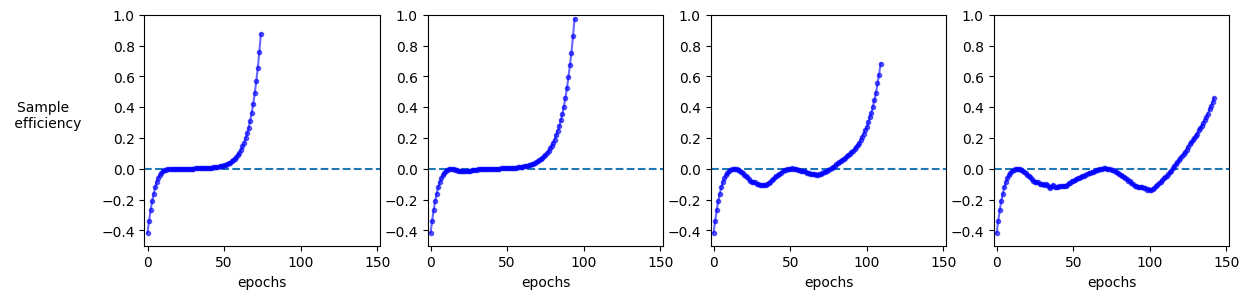

In [131]:
plt.rcParams["font.family"] = "sans-serif"

# Hyperparameters
rb_sizes = [128,256,512,1024]
fig,ax = plt.subplots(2,len(rb_sizes),figsize=(3.5*len(rb_sizes),6))


se_fig, se_ax = plt.subplots(1,len(rb_sizes),figsize=(3.5*len(rb_sizes),3))

samples_dict = {}
buffer_states_history_dict = {}
num_epochs = {}

for i, rb_size in enumerate(rb_sizes):

  joint_policy_trajectory, acts_history, buffer_states_history, epoch_num, samples_list = online_maddpg_limit_policy(
      q_fn,
      buffer_size=rb_size,
      batch_size=32,
      lr=lr,
      policy_init=policy_init,
      epochs=epochs,
  )

  samples_dict[str(rb_size)] = samples_list
  buffer_states_history_dict[str(rb_size)] = buffer_states_history
  num_epochs[str(rb_size)] = epoch_num

  se_ax[i].axhline(0, linestyle='--')

  # Plot trajectory
  l1, l2 = plot_surface_trajectory(q_fn, joint_policy_trajectory[:epoch_num-1,:], ax[1,i], title=f"trajectory_{rb_size}")
  plot_sample_efficiency_curve(q_fn, joint_policy_trajectory[:epoch_num-1,:], se_ax[i],150)
  plot_rb_with_samples(ax[0,i],samples_list[-1].experience, buffer_states_history[-1], epoch_num,alpha = 0.5)

  # sm = plt.cm.ScalarMappable(cmap="inferno_r",norm=matplotlib.colors.Normalize(vmin=-5, vmax=58))
  # fig.colorbar(sm, cax=cbar_ax)

  for j in range(2):
    if i!=0:
      ax[j,i].set_yticks([])
    if j!=1:
      ax[j,i].set_xticks([])

  ax[1,i].set_aspect('equal')
  ax[0,i].set_aspect('equal')

  ax[0,i].set_title("Buffer size "+str(rb_size))

ax[1,0].set_ylabel("Trajectory",rotation="horizontal",labelpad=40)
se_ax[0].set_ylabel("Sample \n efficiency",rotation="horizontal",labelpad=40)
ax[0,0].set_ylabel("Final \n buffer state",rotation="horizontal",labelpad=40)

fig.subplots_adjust(wspace=-0.1)

fig.text(0.5, 0.04, 'Action x', ha='center')
fig.text(0.1, 0.5, 'Action y', va='center', rotation='vertical')

fig.savefig("off-policy-plot.pdf",format="pdf")
se_fig.savefig("off-policy-plot_se.pdf",format="pdf")
plt.show()

# Offline MADDPG
We have seen that using off-policy data negatively impacts the performance of MADDPG - and of policy gradient methods, in general. \\
Now, let us consider fully offline MADDPG - where the data sampled is entirely independent of the current policy.

## Utils

In [132]:
# @title Offline MADDPG implementation

def offline_maddpg(q_fn, dataset, seed=42, batch_size=32, epochs=80, lr=5e-2, policy_init=(-0.6,0.65)):
  key = jax.random.PRNGKey(seed)

  x_params, y_params = make_policy(key, policy_init)
  opt = optax.sgd(lr)
  x_opt_state = opt.init(x_params)
  y_opt_state = opt.init(y_params)

  # For plotting the joint policy trajectory
  joint_policy_trajectory = jnp.zeros(shape=(epochs+1, 2))

  # Add initial joint-policy
  joint_policy = jnp.concatenate([x_params["params"]["Dense_0"]["bias"], y_params["params"]["Dense_0"]["bias"]], axis=0)
  joint_policy_trajectory = joint_policy_trajectory.at[0].set(joint_policy)

  def train(key, x_params, y_params, x_opt_state, y_opt_state):
    def policy_x_loss(params_x, batch):
      act_x = actor.apply(params_x, s0)
      q_val = q_fn(act_x, batch[:, 1:2])
      return -jnp.mean(q_val), act_x

    def policy_y_loss(params_y, batch):
      act_y = actor.apply(params_y, s0)
      q_val = q_fn(batch[:, 0:1], act_y)
      return -jnp.mean(q_val), act_y

    batch_key, key = jax.random.split(key, 2)
    batch = dataset[
        jax.random.choice(batch_key, dataset.shape[0], shape=(batch_size,), replace=False)
    ]

    (loss_x, act_x), grad_x = jax.value_and_grad(policy_x_loss, has_aux=True)(x_params, batch)
    updates_x, x_opt_state = opt.update(grad_x, x_opt_state)
    x_params = optax.apply_updates(x_params, updates_x)

    (loss_y, act_y), grad_y = jax.value_and_grad(policy_y_loss, has_aux=True)(y_params, batch)
    updates_y, y_opt_state = opt.update(grad_y, y_opt_state)
    y_params = optax.apply_updates(y_params, updates_y)

    return x_params, y_params, x_opt_state, y_opt_state
  jit_train = jax.jit(train)


  # MAIN
  for e in range(1, epochs+1):
    x_params, y_params, x_opt_state, y_opt_state = jit_train(key, x_params, y_params, x_opt_state, y_opt_state)
    key, _ = jax.random.split(key)

    # Add latest joint-policy
    joint_policy = jnp.concatenate([x_params["params"]["Dense_0"]["bias"], y_params["params"]["Dense_0"]["bias"]], axis=0)
    joint_policy_trajectory = joint_policy_trajectory.at[e].set(joint_policy)

  return joint_policy_trajectory

In [133]:
# @title Create a uniform, spotlight or replay dataset

def create_uniform_dataset(q_fn: Callable, key: jax.Array, dataset_n: int):
    dataset_domain = jax.random.uniform(
        key=key,
        shape=(dataset_n, 2),
        minval=-1,
        maxval=1,
    )
    q_vals = q_fn(*dataset_domain.T)
    dataset = jnp.concatenate([dataset_domain, q_vals[:, None]], axis=1)

    x_hat, y_hat = jnp.mean(dataset_domain, axis=0)
    return dataset, (x_hat, y_hat)

def create_spotlight_dataset(q_fn: Callable, key: jax.Array, dataset_n: int, spotlight_center: jax.Array = jnp.zeros((2,)), spotlight_radius: float = 0.5):
    # Create a normal distribution around the spotlight center
    dataset_domain = jax.random.normal(
        key=key,
        shape=(dataset_n, 2),
        dtype=jnp.float32
    )
    dataset_domain = dataset_domain * spotlight_radius + spotlight_center
    q_vals = q_fn(*dataset_domain.T)
    dataset = jnp.concatenate([dataset_domain, q_vals[:, None]], axis=1)

    x_hat, y_hat = jnp.mean(dataset_domain, axis=0)
    return dataset, (x_hat, y_hat)

def create_dataset_from_acts_history(acts_history,surface_fn: Callable):
  dataset = jax.vmap(lambda line: jnp.asarray([line[0],line[1],surface_fn(line[0],line[1])]))(acts_history)
  return dataset

In [134]:
# @title Plotting utilities

def plot_real_vector_field(surface_fn: Callable, ax, real_scale, vf_domain_size = 10):

    # Calculate the gradients for the vector field
    surface_fn_grad_x = jax.grad(surface_fn, argnums=0)
    surface_fn_grad_y = jax.grad(surface_fn, argnums=1)

    vf_domain = jnp.linspace(-1.0, 1.0, vf_domain_size)
    for i in range(len(vf_domain)):
        for j in range(len(vf_domain)):
            x_bar = surface_fn_grad_x(vf_domain[i], vf_domain[j])
            y_bar = surface_fn_grad_y(vf_domain[i], vf_domain[j])

            x_unit, y_unit = x_bar / real_scale, y_bar / real_scale
            ax.arrow(vf_domain[i], vf_domain[j], x_unit, y_unit, head_width=0.05, head_length=0.04, fc='blue', ec='blue',label="True field", zorder=1, alpha=0.6)

    # ax.set_xlabel('Action x')
    # ax.set_ylabel('Action y')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

def plot_dataset_vector_field(surface_fn: Callable, x_data: jnp.ndarray, y_data: jnp.ndarray, ax, dataset_scale, vf_domain_size = 10):

    # Calculate the gradients for the vector field
    surface_fn_grad_x = jax.grad(surface_fn, argnums=0)
    surface_fn_grad_y = jax.grad(surface_fn, argnums=1)

    vf_domain = jnp.linspace(-1.0, 1.0, vf_domain_size)
    for i in range(len(vf_domain)):
        for j in range(len(vf_domain)):

            x_ds = jnp.mean(jax.vmap(surface_fn_grad_x, in_axes=(None, 0))(vf_domain[i], y_data))
            y_ds = jnp.mean(jax.vmap(surface_fn_grad_y, in_axes=(0, None))(x_data, vf_domain[j]))

            x_ds_unit, y_ds_unit = x_ds / dataset_scale, y_ds / dataset_scale
            ax.arrow(vf_domain[i], vf_domain[j], x_ds_unit, y_ds_unit, head_width=0.05, head_length=0.04, fc='red', ec='red',label="Induced field", zorder=0, alpha=0.6)

    # ax.set_xlabel('Action x')
    # ax.set_ylabel('Action y')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

## Case Study: Sign agreement
Our familiar example of $f(x,y)=xy$ encourages sign agreement between agent action choices.

In [135]:
# define a polynomial reward function
@jax.jit
def q_fn(x, y):
    return x * y

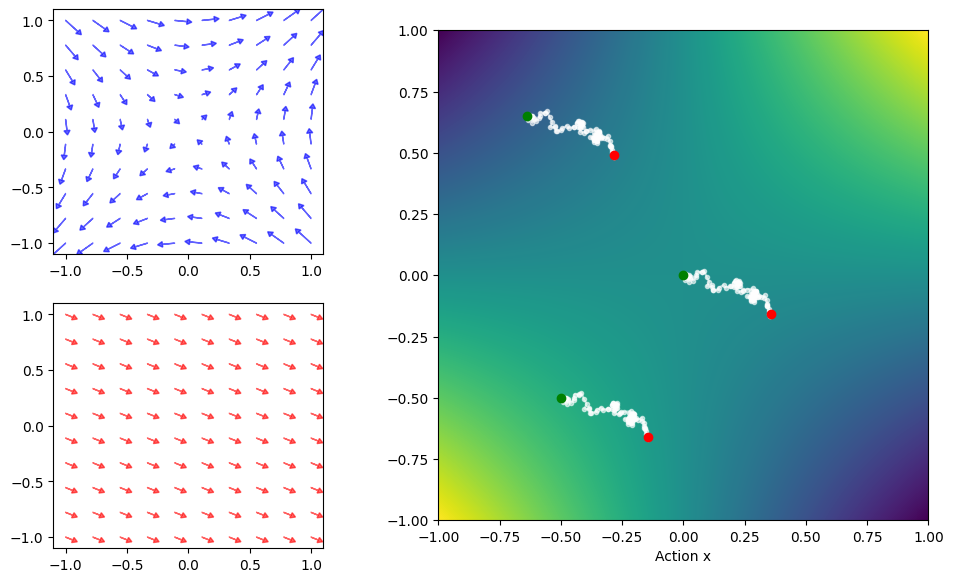

In [136]:
# make a dataset
dataset_size=1_000
key = jax.random.PRNGKey(1)
dataset, (x_hat, y_hat) = create_uniform_dataset(q_fn,key,dataset_size)

# visualise
fig,ax = plt.subplots(2,1,figsize=(12,7))

# plot the polynomial vector field as well as the vector field induced by the dataset
plot_real_vector_field(q_fn,ax[0],10)
plot_dataset_vector_field(q_fn,dataset[:,0], dataset[:,1],ax[1],0.5)

# prepare for plotting multiple trajectories
fig.subplots_adjust(right=0.35)
trajectories_ax = fig.add_axes([0.4, 0.15, 0.5, 0.7])

# Hyperparameters
rb_size = 32
lr = 1e-1
epochs = 100
policy_inits = [(-0.64, 0.65),(0,0),(-0.5,-0.5)]

# try a few different starting points
for policy_init in policy_inits:
  # train offline
  offline_joint_policy_trajectory = offline_maddpg(
      q_fn,
      dataset,
      seed=42,
      batch_size=32,
      epochs=epochs, lr=lr,
      policy_init=policy_init,
  )

  plot_surface_trajectory(q_fn, offline_joint_policy_trajectory, trajectories_ax)

plt.show()

It seems that the learning is entirely independent of the starting point! If we try a few different seeds we can see that the learning is entirely dependent on the seed - in other words, the exact batches of data sampled from the dataset determine the direction of the "policy gradient". \\
Let us try using different datasets.

In [137]:
# @title Plotting utilities

def plot_points(points: jnp.ndarray, ax, alpha: float = 1.0, title: Optional[str] = None):
    """Plots a set of 3d points in 2d, with first two dimensions as x and y, and the third as color."""
    ax.scatter(points[:, 0], points[:, 1], c=points[:, 2], alpha=alpha)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

# for plotting a trajectory against a surface function
def plot_surface_trajectory(surface_fn: Callable, trajectory: jnp.ndarray, ax, step: int = 1, title: Optional[str] = "trajectory"):
    domain = jnp.linspace(-1, 1, 1000)
    ax.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1))

    # Trajectory
    # Extract x and y coordinates
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Plot the trajectory
    ax.plot(x, y, '-w.', alpha=0.6)  # '-o' for lines with markers

    # Mark start and end points
    ax.plot(x[0], y[0], 'go')  # start point
    ax.plot(x[-1], y[-1], 'ro')  # end point

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

def plot_dataset_vector_field(surface_fn: Callable, x_data: jnp.ndarray, y_data: jnp.ndarray, ax, dataset_scale, vf_domain_size = 10):

    # Calculate the gradients for the vector field
    surface_fn_grad_x = jax.grad(surface_fn, argnums=0)
    surface_fn_grad_y = jax.grad(surface_fn, argnums=1)

    vf_domain = jnp.linspace(-1.0, 1.0, vf_domain_size)
    for i in range(len(vf_domain)):
        for j in range(len(vf_domain)):

            x_ds = jnp.mean(jax.vmap(surface_fn_grad_x, in_axes=(None, 0))(vf_domain[i], y_data))
            y_ds = jnp.mean(jax.vmap(surface_fn_grad_y, in_axes=(0, None))(x_data, vf_domain[j]))

            x_ds_unit, y_ds_unit = x_ds / dataset_scale, y_ds / dataset_scale
            ax.arrow(vf_domain[i], vf_domain[j], x_ds_unit, y_ds_unit, head_width=0.05, head_length=0.04, fc='red', ec='red', zorder=0, alpha=0.6)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

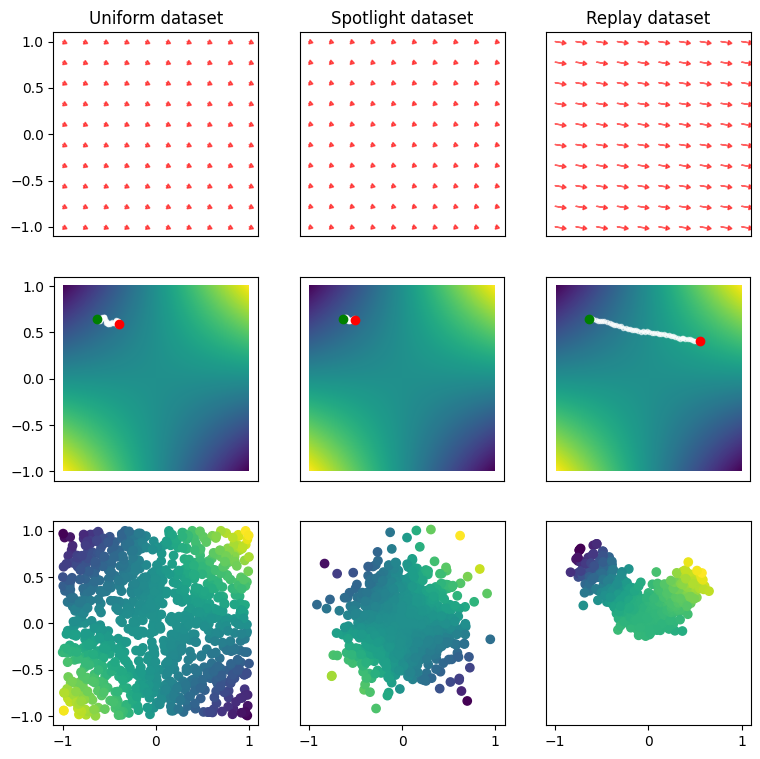

In [138]:
# Make uniform and spotlight datasets
dataset_size=1_000
key = jax.random.PRNGKey(1)
dataset_uniform, (x_hat, y_hat) = create_uniform_dataset(q_fn,key,dataset_size)
dataset_spotlight, (x_hat, y_hat) = create_spotlight_dataset(q_fn,key,dataset_size, spotlight_center = jnp.asarray([0,0]), spotlight_radius = 0.3)

# Hyperparameters
rb_size = 32
lr = 1e-1
epochs = 50
policy_init = (-0.64, 0.65)

# Train online
online_joint_policy_trajectory, acts_history, buffer_states_history = online_maddpg(
    q_fn,
    buffer_size=rb_size,
    lr=lr,
    policy_init=policy_init,
    epochs=epochs,
)

# Make replay dataset
dataset_online = create_dataset_from_acts_history(acts_history,q_fn)

# Pack datasets
datasets = [dataset_uniform,dataset_spotlight,dataset_online]
dataset_names = ["Uniform dataset", "Spotlight dataset","Replay dataset"]

# Prepare axes for plotting
fig,ax = plt.subplots(3,len(datasets),figsize=((9,9)))

for i, dataset in enumerate(datasets):

  # plot the vector field induced by the dataset
  plot_dataset_vector_field(q_fn,dataset[:,0], dataset[:,1],ax[0,i],3)

  # plot dataset itself
  plot_points(dataset,ax[2,i])

  # train offline
  offline_joint_policy_trajectory = offline_maddpg(
      q_fn,
      dataset,
      seed=42,
      batch_size=32,
      epochs=epochs, lr=lr,
      policy_init=policy_init,
  )

  # plot the result of training offline
  plot_surface_trajectory(q_fn, offline_joint_policy_trajectory, ax[1,i])

  for j in range(3):
    ax[j,i].set_xlim(-1.1, 1.1)
    ax[j,i].set_ylim(-1.1, 1.1)
    if i!=0:
      ax[j,i].set_yticks([])
    if j!=2:
      ax[j,i].set_xticks([])

  ax[0,i].set_title(dataset_names[i])

plt.show()


Here we see that training offline results in an overall straight-line trajectory of the policy, with any nonlinearity introduced only by the randomness of batch selection.

### **Exact code used to generate the figures in the paper**

In [139]:
# @title Plotting utilities

def plot_vector_field(surface_fn: Callable, x_data: jnp.ndarray, y_data: jnp.ndarray, ax, real_scale = 10, dataset_scale = 1, vf_domain_size = 10):

    # Calculate the gradients for the vector field
    surface_fn_grad_x = jax.grad(surface_fn, argnums=0)
    surface_fn_grad_y = jax.grad(surface_fn, argnums=1)

    vf_domain = jnp.linspace(-1.0, 1.0, vf_domain_size)
    for i in range(len(vf_domain)):
        for j in range(len(vf_domain)):
            x_bar = surface_fn_grad_x(vf_domain[i], vf_domain[j])
            y_bar = surface_fn_grad_y(vf_domain[i], vf_domain[j])

            x_unit, y_unit = x_bar / real_scale, y_bar / real_scale
            legend_A = ax.arrow(vf_domain[i], vf_domain[j], x_unit, y_unit, head_width=0.05, head_length=0.04, fc='blue', ec='blue', zorder=1, alpha=0.3)

            x_ds = jnp.mean(jax.vmap(surface_fn_grad_x, in_axes=(None, 0))(vf_domain[i], y_data))
            y_ds = jnp.mean(jax.vmap(surface_fn_grad_y, in_axes=(0, None))(x_data, vf_domain[j]))

            x_ds_unit, y_ds_unit = x_ds / dataset_scale, y_ds / dataset_scale
            legend_B = ax.arrow(vf_domain[i], vf_domain[j], x_ds_unit, y_ds_unit, head_width=0.05, head_length=0.04, fc='red', ec='red', zorder=0, alpha=0.8)

    ax.set_xlabel('Action x')
    ax.set_ylabel('Action y')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

    return legend_A, legend_B

# for plotting a trajectory against a surface function
def plot_surface_trajectory(surface_fn: Callable, trajectory: jnp.ndarray, ax, step: int = 1):
    domain = jnp.linspace(-1, 1, 1000)
    ax.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1))

    # Trajectory
    # Extract x and y coordinates
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Plot the trajectory
    ax.plot(x, y, '-w.', alpha=0.6)  # '-o' for lines with markers

    # Mark start and end points
    ax.plot(x[0], y[0], 'go')  # start point
    ax.text(x[0]-0.03,y[0]+0.05, 'start')
    ax.plot(x[-1], y[-1], 'ro')  # end point
    ax.text(x[-1],y[-1]-0.08, 'end')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('Action x')
    ax.set_ylabel('Action y')

# plot the dataset as scattered points
def plot_points(points: jnp.ndarray, ax, alpha: float = 1.0, title: Optional[str] = None):
    """Plots a set of 3d points in 2d, with first two dimensions as x and y, and the third as color."""
    ax.scatter(points[:, 0], points[:, 1], c=points[:, 2], alpha=alpha)

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

    ax.set_xlabel('Action x')
    ax.set_ylabel('Action y')

In [140]:
# make a uniform dataset
dataset_size = 500
key = jax.random.PRNGKey(6)
dataset, (x_hat, y_hat) = create_uniform_dataset(q_fn,key,dataset_size)
print(x_hat)
print(y_hat)

-0.019376181
0.03767543


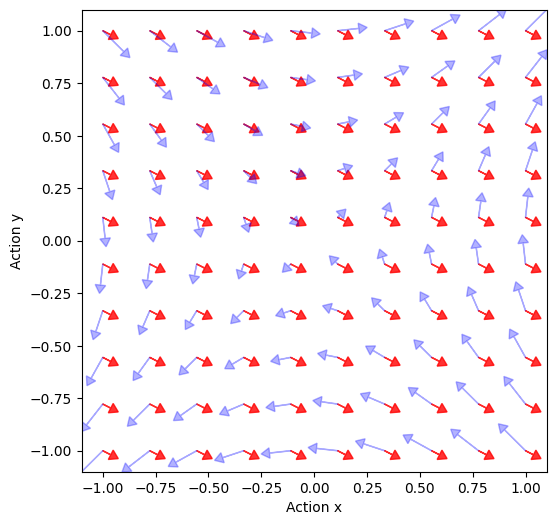

<Figure size 640x480 with 0 Axes>

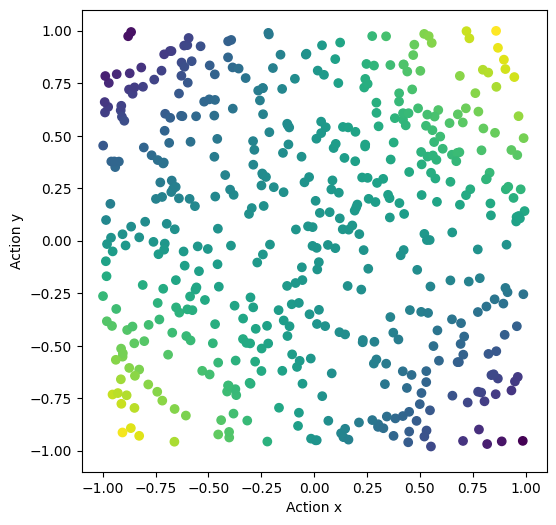

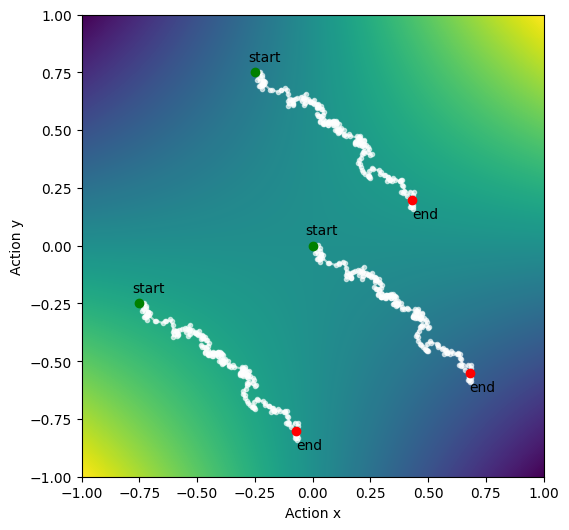

In [141]:
plot_size = 6

# Plot the polynomial vector field as well as the vector field induced by the dataset
fig, ax = plt.subplots(1,1)
la, lb = plot_vector_field(q_fn, dataset[:,0], dataset[:,1],ax)

# Show, edit and save plot
plt.gcf().set_size_inches(plot_size,plot_size)

fig2 = plt.figure("Legend plot")
fig2.legend([la,lb],['True Field', 'Induced Field'],loc='upper center',ncol=2)#,bbox_to_anchor=(0.5, -0.1),ncol=2)
fig2.savefig('vector-field-legend-xy.pdf',bbox_inches='tight')
fig.savefig('vector-field-xy.pdf', transparent=True)#,pad_inches="0.5",bbox_inches=bbox)
plt.show()

# Plot the dataset itself
fig, ax = plt.subplots(1,1)
plot_points(dataset,ax)

# Show, edit and save plot
plt.gcf().set_size_inches(plot_size,plot_size)
plt.savefig('dataset-uniform-xy.pdf', transparent=True)#,bbox_inches=bbox)
plt.show()

# Hyperparameters
rb_size = 32
lr = 1e-1
epochs = 200
policy_inits = [(-0.25, 0.75),(0,0),(-0.75,-0.25)]

fig, ax = plt.subplots(1,1)

for policy_init in policy_inits:
  # Train offline
  offline_joint_policy_trajectory = offline_maddpg(
        q_fn,
        dataset,
        seed=45,
        batch_size=32,
        epochs=epochs,
        lr=lr,
        policy_init=policy_init,
    )

  plot_surface_trajectory(q_fn,offline_joint_policy_trajectory,ax)

plt.gcf().set_size_inches(plot_size,plot_size)
plt.savefig('trajectories-xy.pdf', transparent=True)#,bbox_inches=bbox)
plt.show()


## Case Study: Action agreement
We move to a second dynamic between agents to help build our intuition. A polynomial which encourages action agreement is $f(x,y) = -(x-y)^2$. For this polynomial, the maximum is found everywhere where $x=y$.

In [142]:
# define a polynomial reward function
@jax.jit
def q_fn(x, y):
    return -(x - y)**2

# visualise the function
interact_plot(0,1,q_fn)

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0), FloatSlider(value=0.0, descr…

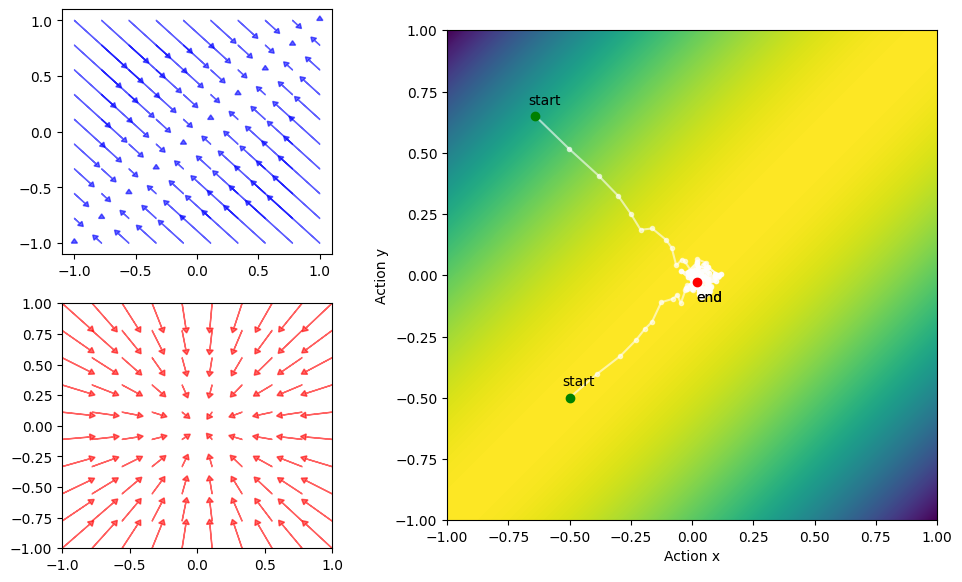

In [143]:
# make a dataset
dataset_size=1_000
key = jax.random.PRNGKey(1)
dataset, (x_hat, y_hat) = create_uniform_dataset(q_fn,key,dataset_size)

# visualise
fig,ax = plt.subplots(2,1,figsize=(12,7))

# plot the polynomial vector field as well as the vector field induced by the dataset
plot_real_vector_field(q_fn,ax[0],10)
plot_dataset_vector_field(q_fn,dataset[:,0], dataset[:,1],ax[1],10)

# prepare for plotting multiple trajectories
fig.subplots_adjust(right=0.35)
trajectories_ax = fig.add_axes([0.4, 0.15, 0.5, 0.7])

# Hyperparameters
rb_size = 32
lr = 1e-1
epochs = 100
policy_inits = [(-0.64, 0.65),(-0.5,-0.5)]

# try a few different starting points
for policy_init in policy_inits:
  # train offline
  offline_joint_policy_trajectory = offline_maddpg(
      q_fn,
      dataset,
      seed=42,
      batch_size=32,
      epochs=epochs, lr=lr,
      policy_init=policy_init,
  )

  plot_surface_trajectory(q_fn, offline_joint_policy_trajectory, trajectories_ax)

plt.show()

It seems that under the uniform dataset, MADDPG converges to the correct point when training offline.

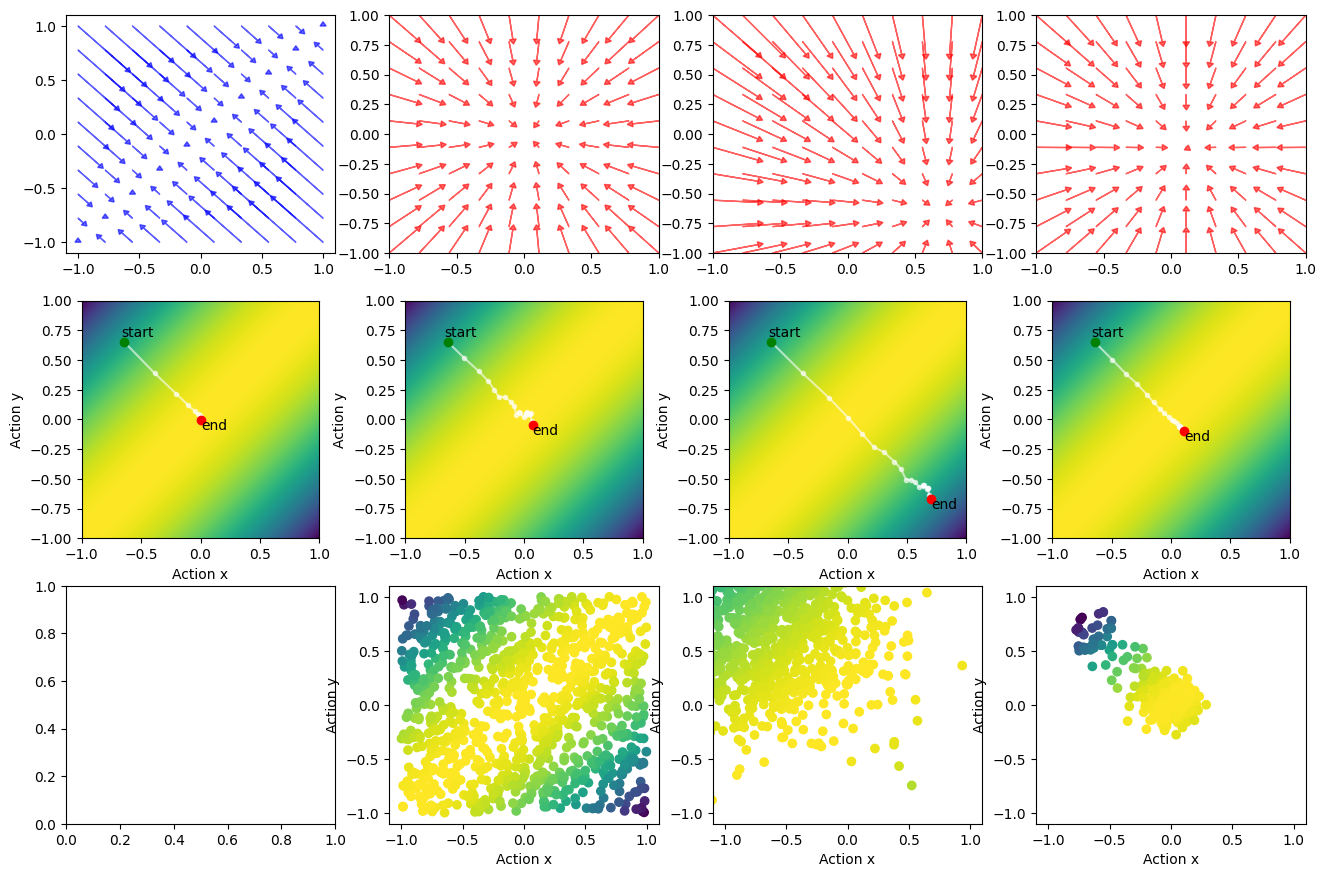

In [144]:
# Make uniform and spotlight datasets
dataset_size=1_000
key = jax.random.PRNGKey(1)
dataset_uniform, (x_hat, y_hat) = create_uniform_dataset(q_fn,key,dataset_size)
dataset_spotlight, (x_hat, y_hat) = create_spotlight_dataset(q_fn,key,dataset_size, spotlight_center = jnp.asarray([-0.64, 0.65]), spotlight_radius = 0.5)

# Hyperparameters
rb_size = 32
lr = 1e-1
epochs = 20
policy_init = (-0.64, 0.65)

# Train online
online_joint_policy_trajectory, acts_history, buffer_states_history = online_maddpg(
    q_fn,
    buffer_size=rb_size,
    lr=lr,
    policy_init=policy_init,
    epochs=epochs,
)

# Make replay dataset
dataset_online = create_dataset_from_acts_history(acts_history,q_fn)

datasets = [dataset_uniform,dataset_spotlight,dataset_online]

# visualise
fig,ax = plt.subplots(3,len(datasets)+1,figsize=((5*len(datasets)+1),10.5))

# plot the polynomial vector field
plot_real_vector_field(q_fn, ax[0,0], 10)
plot_surface_trajectory(q_fn, online_joint_policy_trajectory, ax[1,0])

for i, dataset in enumerate(datasets):

  # plot the vector field induced by the dataset
  plot_dataset_vector_field(q_fn,dataset[:,0], dataset[:,1],ax[0,i+1],10)

  # plot dataset itself
  plot_points(dataset,ax[2,i+1])

  # train offline
  offline_joint_policy_trajectory = offline_maddpg(
      q_fn,
      dataset,
      seed=42,
      batch_size=32,
      epochs=epochs, lr=lr,
      policy_init=policy_init,
  )

  # plot the result of training offline
  plot_surface_trajectory(q_fn, offline_joint_policy_trajectory, ax[1,i+1])

plt.show()

## Case Study: Twin optima
Finally, we have the case where only two optima exist. The polynomial $$R=-A(a_x^2+a_y^2) - B(a_x a_y)^2 + Ca_x a_y $$ fulfils this requirement under the condition that $ \{A>0, B>0, C>2A\}$. Then the optima are at $a_x = \pm\sqrt{(C-2A)/2B}$.

In [145]:
# @title Plotting utilities (run before the next cell)
def plot_surface(surface_fn: Callable,optima):
    domain = jnp.linspace(-1, 1, 1000)
    plt.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1))
    plt.colorbar().set_label('Reward')
    plt.scatter(optima[0],optima[1],c='green')

    plt.xlabel('Action x')
    plt.ylabel('Action y')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    plt.gcf().set_size_inches(5,4)
    plt.title("Reward function surface")

def interact_plot(x,y,surface_fn,optima):
  # we use a closure to make the interaction flexible wrt surface function and optima
  @interact(x=(-1,1,0.1),y=(-1,1,0.1))
  def plot_point_on_surface(x,y):
    plot_surface(surface_fn,optima)

    plt.scatter(x,y,c="black")
    plt.text(x-0.3,y+0.05,"Reward: %.2f" % surface_fn(x,y))

    plt.show()

In [146]:
a = 1
b = 4
c = 5

# define a polynomial reward function
def basic_q_fn(x, y):
    return -a*(x**2+y**2)-b*(x**2*y**2)+c*x*y

vector_q = np.vectorize(basic_q_fn)
q_fn = jax.jit(basic_q_fn)

optimum_positive = np.sqrt((c-2*a)/(2*b))

optima = np.array([[optimum_positive,-optimum_positive],[optimum_positive,-optimum_positive]])

# visualise the function
interact_plot(0,1,vector_q,optima)

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0), FloatSlider(value=0.0, descr…

We can also view this case in three dimensions.

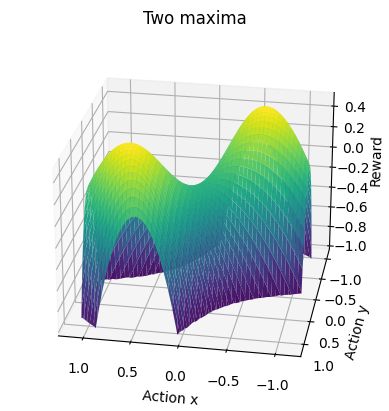

In [147]:
# @title Plot in three dimensions
minx = miny = -1.1
maxx = maxy = 1.1

max_pt = np.sqrt(0.5)

# Creating data
x = np.linspace(minx,maxx, 1000)
y = np.linspace(miny,maxy, 1000)
X, Y = np.meshgrid(x, y)
Z = vector_q(X,Y)

# Creating a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# limit z axis for better visibility
Z[Z<-1]= np.nan

# Plotting the basic 3D surface
ax.set_zlim(-1,0.5)
ax.plot_surface(X,Y,Z, cmap='viridis')

# Customizing the plot
ax.set_xlabel('Action x')
ax.set_ylabel('Action y')
ax.set_zlabel('Reward')
ax.set_title('Two maxima')
ax.view_init(25,100)

# Displaying the plot
plt.show()

Let us see what performance is generated by various datasets for this reward landscape.

The try a few approaches:
- A spotlight dataset of increasing size
- A uniform dataset
- A replay dataset

In [148]:
# @title Plotting utilities

def plot_points(points: jnp.ndarray, ax, alpha: float = 1.0, title: Optional[str] = None):
    """Plots a set of 3d points in 2d, with first two dimensions as x and y, and the third as color."""
    ax.scatter(points[:, 0], points[:, 1], c=points[:, 2], alpha=alpha)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

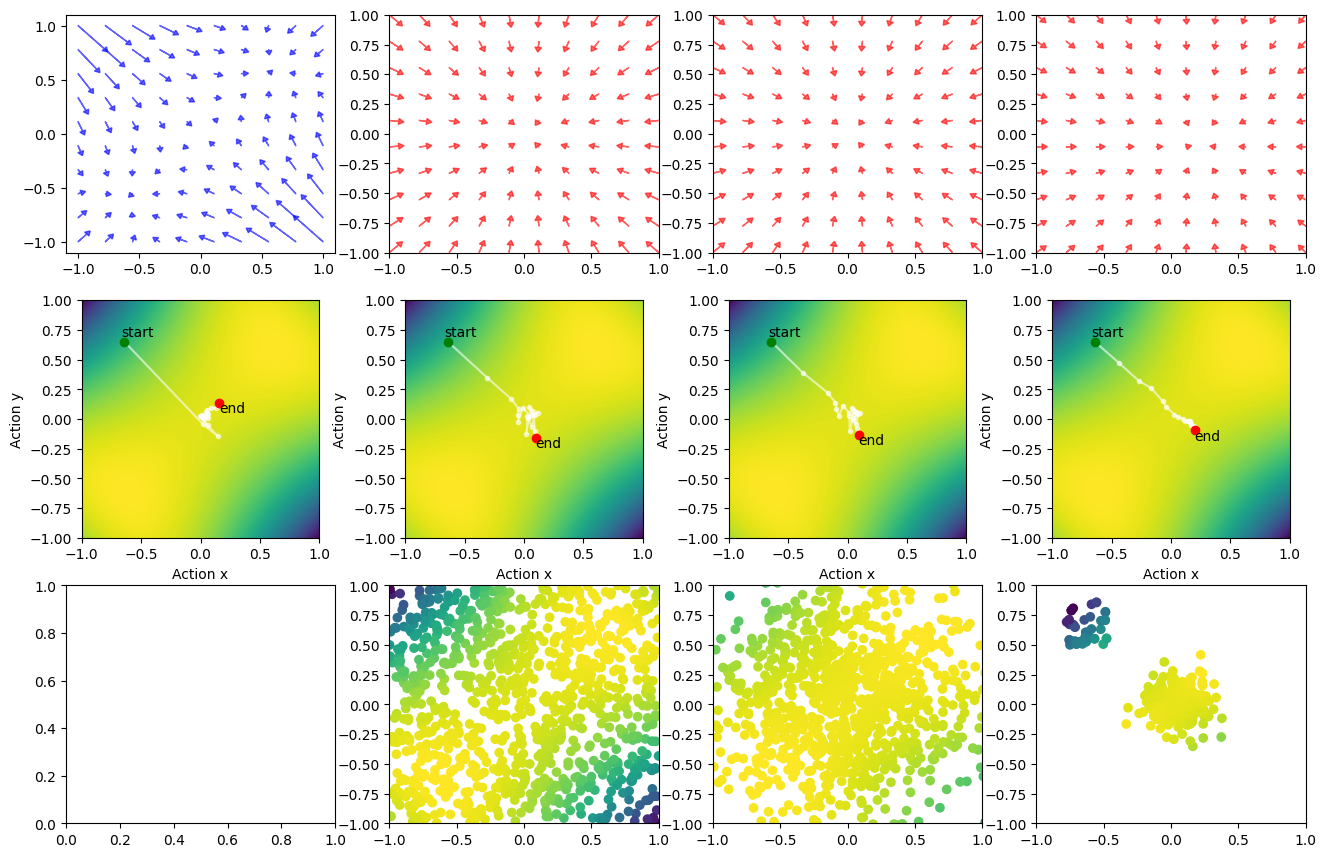

In [149]:
# Make uniform and spotlight datasets
dataset_size=1_000
key = jax.random.PRNGKey(1)
dataset_uniform, (x_hat, y_hat) = create_uniform_dataset(q_fn,key,dataset_size)
dataset_spotlight, (x_hat, y_hat) = create_spotlight_dataset(q_fn,key,dataset_size, spotlight_center = jnp.asarray([0,0]), spotlight_radius = 0.5)

# Hyperparameters
rb_size = 32
lr = 1e-1
epochs = 20
policy_init = (-0.64, 0.65)

# Train online
online_joint_policy_trajectory, acts_history, buffer_states_history = online_maddpg(
    q_fn,
    buffer_size=rb_size,
    lr=lr,
    policy_init=policy_init,
    epochs=epochs,
)

# Make replay dataset
dataset_online = create_dataset_from_acts_history(acts_history,q_fn)

datasets = [dataset_uniform,dataset_spotlight,dataset_online]

# visualise
fig,ax = plt.subplots(3,len(datasets)+1,figsize=((5*len(datasets)+1),10.5))

# plot the polynomial vector field
plot_real_vector_field(q_fn, ax[0,0], 70)
plot_surface_trajectory(q_fn, online_joint_policy_trajectory, ax[1,0])

for i, dataset in enumerate(datasets):

  # plot the vector field induced by the dataset
  plot_dataset_vector_field(q_fn,dataset[:,0], dataset[:,1],ax[0,i+1],70)

  # plot dataset itself
  plot_points(dataset,ax[2,i+1])

  # train offline
  offline_joint_policy_trajectory = offline_maddpg(
      q_fn,
      dataset,
      seed=42,
      batch_size=32,
      epochs=epochs, lr=lr,
      policy_init=policy_init,
  )

  # plot the result of training offline
  plot_surface_trajectory(q_fn, offline_joint_policy_trajectory, ax[1,i+1])

plt.show()

### Exact code used to generate plots in the paper

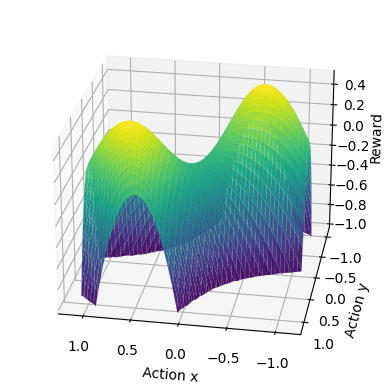

In [150]:
minx = miny = -1.1
maxx = maxy = 1.1

max_pt = np.sqrt(0.5)

# Creating data
x = np.linspace(minx,maxx, 1000)
y = np.linspace(miny,maxy, 1000)
X, Y = np.meshgrid(x, y)
Z = vector_q(X,Y)

# Creating a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# limit z axis for better visibility
Z[Z<-1]= np.nan

# Plotting the basic 3D surface
ax.set_zlim(-1,0.5)
ax.plot_surface(X,Y,Z, cmap='viridis')

# Customizing the plot
ax.set_xlabel('Action x')
ax.set_ylabel('Action y')
ax.set_zlabel('Reward')
ax.view_init(25,100)

# Displaying the plot
plt.savefig('2-maxima.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [151]:
  # @title Plotting utilities

def plot_points(points: jnp.ndarray, ax, surface_fn, alpha: float = 1.0, title: Optional[str] = None):
    """Plots a set of 3d points in 2d, with first two dimensions as x and y, and the third as color."""
    ax.scatter(points[:, 0], points[:, 1], c=surface_fn(points[:, 0],points[:, 1]), alpha=alpha,vmin=-1,vmax=0.5)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")


# for plotting a trajectory against a surface function
def plot_surface_trajectory(surface_fn: Callable, trajectory: jnp.ndarray, ax, step: int = 1, title: Optional[str] = "trajectory"):
    domain = jnp.linspace(-1, 1, 1000)
    ax.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1),clim=(-1,0.5))

    # Trajectory
    # Extract x and y coordinates
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Plot the trajectory
    ax.plot(x, y, '-w.', alpha=0.6)  # '-o' for lines with markers

    # Mark start and end points
    label1, = ax.plot(x[0], y[0], 'go',label="start")  # start point
    label2, = ax.plot(x[-1], y[-1], 'ro',label="end")  # end point

    ax.text(x[0]-0.03,y[0]+0.1, 'start',fontsize=7,c="white")
    ax.text(x[-1],y[-1]-0.2, 'end',fontsize=7)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    return label1, label2

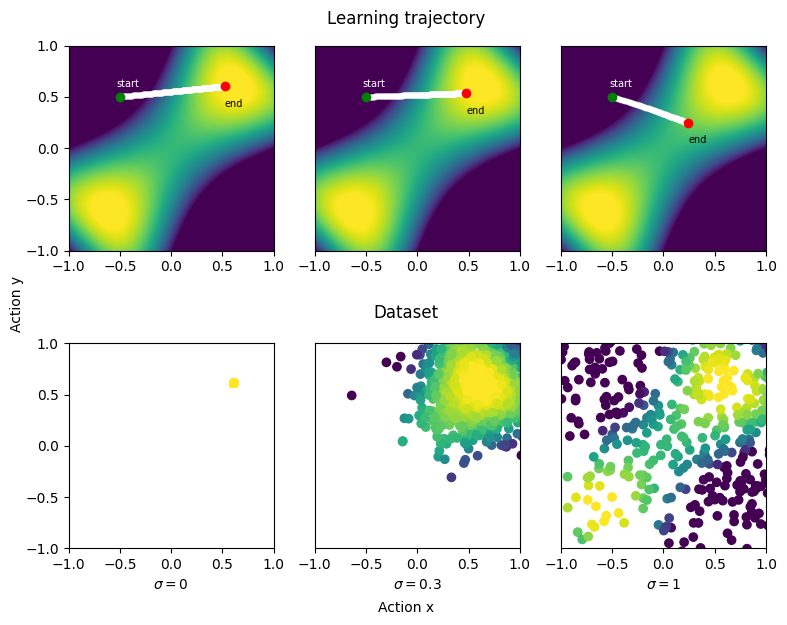

In [152]:
# Make uniform and spotlight datasets
dataset_size=1_000
key = jax.random.PRNGKey(1)

radii = [0,0.3,1]

datasets = []
for radius in radii:
  # use commenting to choose where you want your dataset centered
  # dataset, (x_hat, y_hat) = create_spotlight_dataset(q_fn,key,dataset_size, spotlight_center = jnp.asarray([0,0]), spotlight_radius = radius)
  dataset, (x_hat, y_hat) = create_spotlight_dataset(q_fn,key,dataset_size, spotlight_center = jnp.asarray([optimum_positive,optimum_positive]), spotlight_radius = radius)
  datasets.append(dataset)

# Hyperparameters
rb_size = 32
lr = 5e-4
epochs = 1000
policy_init = (-0.5,0.5)

# visualise
fig,ax = plt.subplots(2,len(datasets),figsize=(3*len(datasets),14))

for i, dataset in enumerate(datasets):

  # plot dataset itself
  plot_points(dataset,ax[1,i],q_fn)
  ax[1,i].set_xlabel("Action x")

  # train offline
  offline_joint_policy_trajectory = offline_maddpg(
      q_fn,
      dataset,
      seed=42,
      batch_size=32,
      epochs=epochs, lr=lr,
      policy_init=policy_init,
  )

  # plot the result of training offline
  plot_surface_trajectory(q_fn, offline_joint_policy_trajectory, ax[0,i])
  if i!=0:
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])
    ax[0,i].set_ylabel("")
  ax[0,i].set_xlabel("")
  ax[1,i].set_xlabel("$\sigma = $"+str(radii[i]))

fig.subplots_adjust(top=0.5)
fig.text(0.5, 0.08, 'Action x', ha='center')
fig.text(0.06, 0.3, 'Action y', va='center', rotation='vertical')
fig.text(0.5, 0.50, 'Learning trajectory', ha='center',fontsize=12)
fig.text(0.5, 0.29, 'Dataset', ha='center',fontsize=12)

plt.savefig("2peaks-stddev.pdf",format='pdf',bbox_inches='tight')
plt.show()

# Proximal Joint-Action Prioritisation
We have now established that multi-agent policy gradient methods with a gradient based on a static dataset do not necessarily learn according to gradients that are representative of the true gradient of the policy.
It remains to propose a solution.
One way to reintroduce some dynamic component into learning with respect to other agents' policies is to try to keep learning close to the current policy available for other agents. In other words, to sample the replay buffer strategically so that current agent learning is based as closely as possible on other agents' current learned policies.

Proximal joint-action prioritisation (PJAP) does this.

## Utils

In [153]:
# @title Offline MADDPG with PJAP
def polygame_offline_maddpg_rb(
    q_fn: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray],
    key: jax.Array,
    dataset: jnp.ndarray,
    epochs: int = 1000,
    batch_size: Optional[int] = None,
    policy_init: Tuple[float, float] = (0.0, 0.0),
    lr: float = 1e-1,
    zeta: float = 10.0,
):
    stable_key = copy.deepcopy(key)

    if batch_size is None:
        batch_size = dataset.shape[0]

    x_params, y_params = make_policy(key, policy_init)

    opt = optax.sgd(lr)
    opt_state_x = opt.init(x_params)
    opt_state_y = opt.init(y_params)

    @jax.jit
    def policy_x_loss(params_x, batch):
        act_x = actor.apply(params_x, s0)
        q_val = q_fn(act_x, batch[:, 1:2])
        return -jnp.mean(q_val), act_x

    @jax.jit
    def policy_y_loss(params_y, batch):
        act_y = actor.apply(params_y, s0)
        q_val = q_fn(batch[:, 0:1], act_y)
        return -jnp.mean(q_val), act_y

    acts_trajectory = jnp.zeros(shape=(epochs, 2))

    # make prioritised replay buffer from flashbax
    buffer = fbx.make_prioritised_flat_buffer(
        max_length=dataset.shape[0] + 1,
        min_length=0,
        sample_batch_size=batch_size,
        priority_exponent=1.0,
        add_sequences=True,
    )
    buffer_full = fbx.make_prioritised_flat_buffer(
        max_length=dataset.shape[0] + 1,
        min_length=0,
        sample_batch_size=8 * batch_size, #dataset.shape[0],
        add_sequences=True,
        priority_exponent=0.0,
    )
    buffer_state =  buffer.init(dataset[0])
    buffer_state = buffer.add(buffer_state, dataset)

    zeta_t = zeta # 0.0
    # Keep track of all the batches seen
    batches = []
    priority_record = []
    distance_record = jnp.zeros(shape=(epochs,))
    for e in range(epochs):
        # Current policy position
        pi_curr = jnp.concatenate([actor.apply(x_params, s0), actor.apply(y_params, s0)])

        # Get a batch from the dataset as jnp array
        batch_key, key = jax.random.split(key, 2)
        samples = jax.jit(buffer.sample)(buffer_state, batch_key)

        # get data itself
        batch = samples.experience.first
        batches.append(batch)

        # Record the distance between the current policy and the batch
        batch_dist = jnp.mean(
            # L1
            jnp.mean(jnp.abs(batch[:, 0:2] - pi_curr), axis=1),
        )
        distance_record = distance_record.at[e].set(batch_dist)

        (loss_x, act_x), grad_x = jax.value_and_grad(policy_x_loss, has_aux=True)(x_params, batch)
        updates_x, opt_state_x = opt.update(grad_x, opt_state_x)
        x_params = optax.apply_updates(x_params, updates_x)

        (loss_y, act_y), grad_y = jax.value_and_grad(policy_y_loss, has_aux=True)(y_params, batch)
        updates_y, opt_state_y = opt.update(grad_y, opt_state_y)
        y_params = optax.apply_updates(y_params, updates_y)

        acts = jnp.concatenate([act_x, act_y], axis=0)
        acts_trajectory = acts_trajectory.at[e].set(acts)

        if e % 1 == 0:
            for _ in range(1):
                # sample a batch and update the priorities
                batch_key, key = jax.random.split(key, 2)
                batch = buffer_full.sample(buffer_state, batch_key)
                samples = batch.experience.first[:, 0:2]

                indices = batch.indices
                dist = jnp.mean(jnp.abs(samples - pi_curr), axis=1)

                new_priorities = jnp.exp(-zeta_t * dist ** 2)
                buffer_state = jax.jit(buffer.set_priorities, donate_argnums=0)(buffer_state, indices, new_priorities)
                # print(f"New priorities: {jnp.mean(new_priorities)}")

        full_exper_state = buffer_state.experience[0, :buffer_state.current_index, 0:2]
        priority_record.append(
            jnp.concatenate([
                full_exper_state,
                sum_tree.get(
                    buffer_state.priority_state,
                    jnp.arange(full_exper_state.shape[0])[:, None]
                )],
            axis=1)
        )

    return acts_trajectory, (x_params, y_params), jnp.array(batches), priority_record, distance_record

In [154]:
# @title Vanilla offline MADDPG with extra distance logging
def polygame_offline_maddpg_old(
    q_fn: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray],
    key: jax.Array,
    dataset: jnp.ndarray,
    epochs: int = 1000,
    batch_size: Optional[int] = None,
    policy_init: Tuple[float, float] = (0.0, 0.0),
    lr: float = 1e-1,
):
    if batch_size is None:
        batch_size = dataset.shape[0]

    x_params, y_params = make_policy(key, policy_init)

    opt = optax.sgd(lr)
    opt_state_x = opt.init(x_params)
    opt_state_y = opt.init(y_params)

    @jax.jit
    def policy_x_loss(params_x, batch):
        act_x = actor.apply(params_x, s0)
        q_val = q_fn(act_x, batch[:, 1:2])
        return -jnp.mean(q_val), act_x

    @jax.jit
    def policy_y_loss(params_y, batch):
        act_y = actor.apply(params_y, s0)
        q_val = q_fn(batch[:, 0:1], act_y)
        return -jnp.mean(q_val), act_y

    acts_trajectory = jnp.zeros(shape=(epochs, 2))
    batches = []
    distance_record = jnp.zeros(shape=(epochs,))
    for e in range(epochs):
        # Get a batch from the dataset as jnp array
        batch_key, key = jax.random.split(key, 2)
        batch = dataset[
            jax.random.choice(
                batch_key,
                dataset.shape[0],
                shape=(batch_size,),
                replace=False,
            )
        ]

        pi_curr = jnp.concatenate([actor.apply(x_params, s0), actor.apply(y_params, s0)])
        # Record the distance between the current policy and the batch
        batch_dist = jnp.mean(
            # L1
            jnp.mean(jnp.abs(batch[:, 0:2] - pi_curr), axis=1),
        )
        distance_record = distance_record.at[e].set(batch_dist)

        batches.append(batch)

        (loss_x, act_x), grad_x = jax.value_and_grad(policy_x_loss, has_aux=True)(x_params, batch)
        updates_x, opt_state_x = opt.update(grad_x, opt_state_x)
        x_params = optax.apply_updates(x_params, updates_x)

        (loss_y, act_y), grad_y = jax.value_and_grad(policy_y_loss, has_aux=True)(y_params, batch)
        updates_y, opt_state_y = opt.update(grad_y, opt_state_y)
        y_params = optax.apply_updates(y_params, updates_y)

        acts = jnp.concatenate([act_x, act_y], axis=0)
        acts_trajectory = acts_trajectory.at[e].set(acts)

    return acts_trajectory, (x_params, y_params), jnp.array(batches), distance_record

In [155]:
# @title Create a gif of priorities evolving over time
def plot_priority_record(priority_record, title="priority_record"):
    """Plot the priority record over time as a gif.

    Each point is coloured by the priority value.
    shape is (400, 1001, 3)
    where 400 is the number of frames
    1001 is the number of points
    3 is the (x,y,c)

    Args:
        priority_record (_type_): _description_
    """
    fig, ax = plt.subplots()
    sc = ax.scatter([], [], c=[], vmin=0, vmax=1, cmap='coolwarm')

    ax.set_xlabel('Action x')
    ax.set_ylabel('Action y')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal')
    plt.colorbar(sc)

    all_points = jnp.array([]).reshape(0, 3)

    def update(frame):
        nonlocal all_points
        points = priority_record[frame]
        # all_points = np.vstack((all_points, points))
        sc.set_offsets(points[:, :2])
        sc.set_array(points[:, 2])
        return sc,

    ani = animation.FuncAnimation(fig, update, frames=len(priority_record), interval=100)
    ani.save(f'{title}.gif', writer='pillow', fps=10)

In [156]:
# @title Example of running a PJAP experiment

dataset_size = 1_000
batch_size = 64

def run_experiment(q_fn, seed, policy_init):
    key = jax.random.PRNGKey(seed)
    uniform_dataset, (x_hat, y_hat) = create_uniform_dataset(q_fn, key, dataset_size)

    offline_maddpg_traj_rb, _, batches_rb, priority_record, distance_record = polygame_offline_maddpg_rb(
        q_fn,
        key,
        epochs=200,
        dataset=uniform_dataset,
        lr=5e-2,
        policy_init=policy_init,
        batch_size=batch_size,
        zeta=50,
    )

    return offline_maddpg_traj_rb, _, batches_rb, priority_record


@jax.jit
def q_fn(x, y):
    return - x ** 4 - y ** 4 + x**2 + y**2 - x * y

offline_maddpg_traj_rb, _, batches_rb, priority_record = run_experiment(q_fn, seed=1, policy_init=(0.25, 0.45))

/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 1001`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:498: UserWarning: `sample_sequence_length` greater than `min_length_time_axis`, therefore overriding `min_length_time_axis`to be set to `sample_sequence_length`, as we need at least `sample_sequence_length` timesteps added to the buffer before we can sample.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 1001`.This allows one to control exactly how many timesteps are stored in the buffer.Note that t

In [157]:
# for plotting a trajectory against a surface function
def plot_surface_trajectory(surface_fn: Callable, trajectory: jnp.ndarray, ax, step: int = 1):
    domain = jnp.linspace(-1, 1, 1000)
    ax.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1))

    # Trajectory
    # Extract x and y coordinates
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Plot the trajectory
    ax.plot(x, y, '-w.', alpha=0.6)  # '-o' for lines with markers

    # Mark start and end points
    ax.plot(x[0], y[0], 'go')  # start point
    ax.text(x[0]-0.03,y[0]+0.05, 'start')
    ax.plot(x[-1], y[-1], 'ro')  # end point
    ax.text(x[-1],y[-1]-0.08, 'end')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('Action x')
    ax.set_ylabel('Action y')

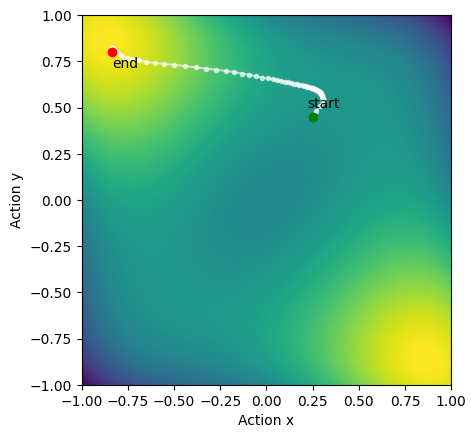

In [158]:

fig, ax = plt.subplots(1,1)

plot_surface_trajectory(q_fn, offline_maddpg_traj_rb,ax)

# uncomment only if you want to build a gif
# plot_priority_record(jnp.array(priority_record))

## MADDPG with PJAP on every failure case we saw before

### Sign agreement (Exact code used to generate plots in the paper)

In [159]:
# define a polynomial reward function
@jax.jit
def q_fn(x, y):
    return x * y

In [160]:
# make a uniform dataset
dataset_size = 500
key = jax.random.PRNGKey(6)
dataset, (x_hat, y_hat) = create_uniform_dataset(q_fn,key,dataset_size)
print(x_hat)
print(y_hat)

-0.019376181
0.03767543


<Figure size 600x600 with 0 Axes>

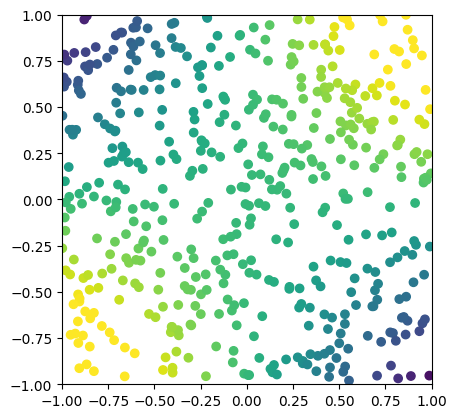

/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 501`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:498: UserWarning: `sample_sequence_length` greater than `min_length_time_axis`, therefore overriding `min_length_time_axis`to be set to `sample_sequence_length`, as we need at least `sample_sequence_length` timesteps added to the buffer before we can sample.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 501`.This allows one to control exactly how many timesteps are stored in the buffer.Note that thi

In [161]:
plot_size = 6

# Show, edit and save plot
plt.gcf().set_size_inches(plot_size,plot_size)


# Plot the dataset itself
fig, ax = plt.subplots(1,1)
plot_points(dataset,ax,q_fn)

# Show, edit and set-uniform-xy.pdf', transparent=True)#,bbox_inches=bbox)
plt.show()

# Hyperparameters
rb_size = 32
lr = 1e-1
epochs = 200
batch_size = 32
policy_inits = [(-0.25, 0.75),(0,0),(-0.75,-0.25)]

# fig, ax = plt.subplots(1,1)

offline_data = {}
offline_pjap_data = {}

# Train offline in versions
for policy_init in policy_inits:

  key = jax.random.PRNGKey(1)

  # Train offline
  acts_trajectory, (x_params, y_params), batches, distance_record = polygame_offline_maddpg_old(
        q_fn,
        key=key,
        dataset=dataset,
        batch_size=batch_size,
        epochs=epochs,
        lr=lr,
        policy_init=policy_init,
    )


  offline_data[str(policy_init)] = (acts_trajectory, (x_params, y_params), batches, distance_record)

  offline_maddpg_traj_rb, _, batches_rb, priority_record, distance_record = polygame_offline_maddpg_rb(
      q_fn,
      key,
      epochs=epochs,
      dataset=dataset,
      lr=lr,
      policy_init=policy_init,
      batch_size=batch_size,
      zeta=50,
  )

  offline_pjap_data[str(policy_init)] = (offline_maddpg_traj_rb, _, batches_rb, priority_record, distance_record)
#   plot_surface_trajectory(q_fn, offline_maddpg_traj_rb,ax)

#   plot_surface_trajectory(q_fn,offline_joint_policy_trajectory,ax)

# plt.gcf().set_size_inches(plot_size,plot_size)
# plt.savefig('trajectories-xy.pdf', transparent=True)#,bbox_inches=bbox)
# plt.show()

In [162]:
# for plotting a trajectory against a surface function
def plot_surface_trajectory(surface_fn: Callable, trajectory: jnp.ndarray, ax, colour, step: int = 1):
    domain = jnp.linspace(-1, 1, 1000)
    ax.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1))

    # Trajectory
    # Extract x and y coordinates
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Plot the trajectory
    ax.plot(x, y, '-w.', c=colour,alpha=0.6)  # '-o' for lines with markers

    # # Mark start and end points
    ax.plot(x[0], y[0], 'wo')  # start point
    # ax.text(x[0]-0.03,y[0]+0.05, 'start')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('Action x')
    ax.set_ylabel('Action y')

In [163]:
# @title Plotting utilities for the PJAP experiments
def plot_dist(distance_record_pjap,distance_record,cols,ax):
  # plot each of the distance records on one plot, where the x-axis is the epochs
  ax.plot(distance_record_pjap, label="MADDPG+PJAP",c=cols[0])
  ax.plot(distance_record, label="MADDPG",c=cols[1])
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Distance")
  ax.legend()

def plot_rewards(rewards_pjap,rewards,cols,ax):
  # plot each of the distance records on one plot, where the x-axis is the epochs
  ax.plot(rewards_pjap, label="MADDPG+PJAP",c=cols[0])
  ax.plot(rewards, label="MADDPG",c=cols[1])
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Reward")
  ax.legend()

# for plotting a trajectory against a surface function
def plot_surface_trajectory(surface_fn: Callable, trajectory: jnp.ndarray, ax, col,step: int = 1, title: Optional[str] = "trajectory"):
    domain = jnp.linspace(-1, 1, 1000)
    ax.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1),clim=(-1,0.5))

    # Trajectory
    # Extract x and y coordinates
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Plot the trajectory
    ax.plot(x, y, '-w.',c=col, alpha=0.6)  # '-o' for lines with markers

    # Mark start and end points
    label1, = ax.plot(x[0], y[0], 'go',label="start")  # start point
    label2, = ax.plot(x[-1], y[-1], 'ro',label="end")  # end point

    # ax.text(x[0]-0.03,y[0]+0.1, 'start',fontsize=7,c="white")
    # ax.text(x[-1],y[-1]-0.2, 'end',fontsize=7)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    return label1, label2

<ipython-input-163-548a034331d6>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-w." (-> color='w'). The keyword argument will take precedence.
  ax.plot(x, y, '-w.',c=col, alpha=0.6)  # '-o' for lines with markers


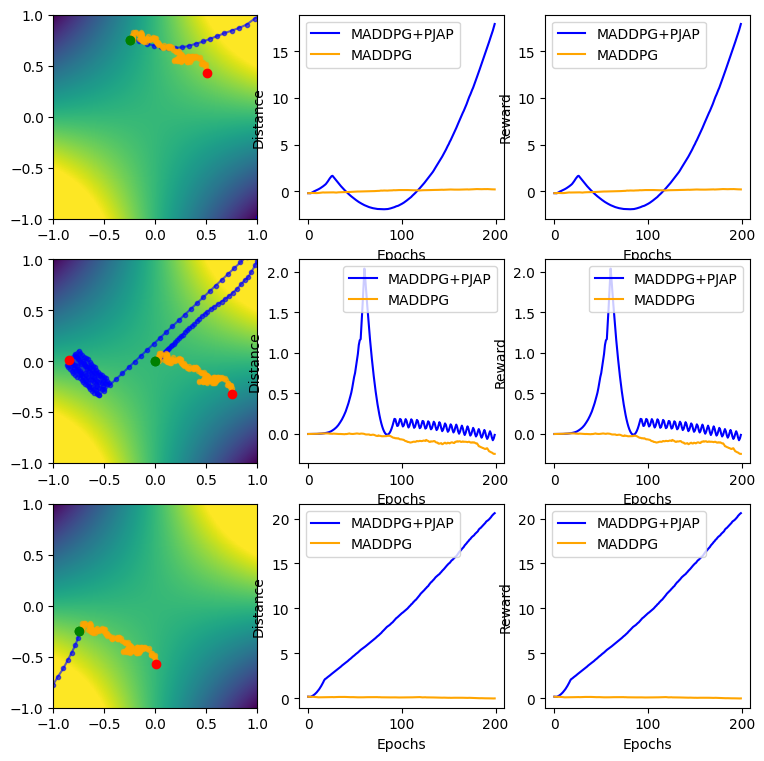

In [164]:
cols = ["blue","orange"]


fig, ax = plt.subplots(len(policy_inits),3,figsize=(3*len(policy_inits),3*len(policy_inits)))

policy_inits = [(-0.25, 0.75),(0,0),(-0.75,-0.25)]
for i,policy_init in enumerate(policy_inits):

  (offline_maddpg_traj_rb, _, batches_rb, priority_record, distance_record_pjap) = offline_pjap_data[str(policy_init)]
  (acts_trajectory, (x_params, y_params), batches, distance_record) = offline_data[str(policy_init)]

  # fig, ax = plt.subplots(1,3,figsize=(10,3))

  # plot trajectories before and after PJAP
  plot_surface_trajectory(q_fn, offline_maddpg_traj_rb,ax[i,0],cols[0])
  plot_surface_trajectory(q_fn,acts_trajectory,ax[i,0],cols[1])

  # plot distance measures
  rewards_pjap = q_fn(offline_maddpg_traj_rb[:, 0], offline_maddpg_traj_rb[:, 1])
  rewards = q_fn(acts_trajectory[:, 0], acts_trajectory[:, 1])

  # plot each of the distance records on one plot, where the x-axis is the epochs
  plot_dist(rewards_pjap,rewards,cols,ax[i,1])

  # plot each of the rewards records on one plot, where the x-axis is the epochs
  plot_rewards(rewards_pjap,rewards,cols,ax[i,2])

  # plt.gcf().set_size_inches(plot_size,plot_size)
plt.savefig("xy-pjap-results.pdf",format="pdf",bbox_inches="tight")
plt.show()

### Action agreement

In [165]:
# @title Plotting utilities (back to interact plot with no optima)
def plot_surface(surface_fn: Callable):
    domain = jnp.linspace(-1, 1, 1000)
    plt.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1))
    # plt.clim(-1, 1)
    plt.colorbar().set_label('Reward')

    plt.xlabel('Action x')
    plt.ylabel('Action y')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    plt.gcf().set_size_inches(5,4)
    plt.title("Reward function surface")

def interact_plot(x,y,surface_fn):
  # using a closure to define the interactive function flexibly
  @interact(x=(-1,1,0.1),y=(-1,1,0.1))
  def plot_point_on_surface(x,y):
    plot_surface(surface_fn)

    plt.scatter(x,y,c="black")
    plt.text(x-0.3,y+0.05,"Reward: %.2f" % surface_fn(x,y))
    plt.show()

In [166]:
# define a polynomial reward function
@jax.jit
def q_fn(x, y):
    return -(x - y)**2

# visualise the function
interact_plot(0,1,q_fn)

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0), FloatSlider(value=0.0, descr…

In [167]:
# Make uniform and spotlight datasets
dataset_size=1_000
key = jax.random.PRNGKey(1)
dataset_uniform, (x_hat, y_hat) = create_uniform_dataset(q_fn,key,dataset_size)
dataset_spotlight, (x_hat, y_hat) = create_spotlight_dataset(q_fn,key,dataset_size, spotlight_center = jnp.asarray([-0.64, 0.65]), spotlight_radius = 0.5)

# Hyperparameters
rb_size = 32
lr = 1e-1
epochs = 40
policy_init = (-0.64, 0.65)

# Train online
online_joint_policy_trajectory, acts_history, buffer_states_history = online_maddpg(
    q_fn,
    buffer_size=rb_size,
    lr=lr,
    policy_init=policy_init,
    epochs=epochs,
)

# Make replay dataset
dataset_online = create_dataset_from_acts_history(acts_history,q_fn)

datasets = [dataset_uniform,dataset_spotlight,dataset_online]

action_data = {}
action_pjap_data = {}

start = time.time()

for i, dataset in enumerate(datasets):

  # plot dataset itself
  plot_points(dataset,ax[1,i],q_fn)
  ax[1,i].set_xlabel("Action x")


  key = jax.random.PRNGKey(1)

  # Train offline
  acts_trajectory, (x_params, y_params), batches, distance_record = polygame_offline_maddpg_old(
        q_fn,
        key=key,
        dataset=dataset,
        batch_size=batch_size,
        epochs=epochs,
        lr=lr,
        policy_init=policy_init,
    )


  action_data[str(i)] = (acts_trajectory, (x_params, y_params), batches, distance_record)

  offline_maddpg_traj_rb, _, batches_rb, priority_record, distance_record = polygame_offline_maddpg_rb(
      q_fn,
      key,
      epochs=epochs,
      dataset=dataset,
      lr=lr,
      policy_init=policy_init,
      batch_size=batch_size,
      zeta=50,
  )

  action_pjap_data[str(i)] = (offline_maddpg_traj_rb, _, batches_rb, priority_record, distance_record)

  print(time.time()-start)

/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 1001`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:498: UserWarning: `sample_sequence_length` greater than `min_length_time_axis`, therefore overriding `min_length_time_axis`to be set to `sample_sequence_length`, as we need at least `sample_sequence_length` timesteps added to the buffer before we can sample.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 1001`.This allows one to control exactly how many timesteps are stored in the buffer.Note that t

15.576524496078491


/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 1001`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:498: UserWarning: `sample_sequence_length` greater than `min_length_time_axis`, therefore overriding `min_length_time_axis`to be set to `sample_sequence_length`, as we need at least `sample_sequence_length` timesteps added to the buffer before we can sample.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 1001`.This allows one to control exactly how many timesteps are stored in the buffer.Note that t

29.30958390235901


/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 673`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:498: UserWarning: `sample_sequence_length` greater than `min_length_time_axis`, therefore overriding `min_length_time_axis`to be set to `sample_sequence_length`, as we need at least `sample_sequence_length` timesteps added to the buffer before we can sample.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 673`.This allows one to control exactly how many timesteps are stored in the buffer.Note that thi

42.55361866950989


<ipython-input-163-548a034331d6>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-w." (-> color='w'). The keyword argument will take precedence.
  ax.plot(x, y, '-w.',c=col, alpha=0.6)  # '-o' for lines with markers


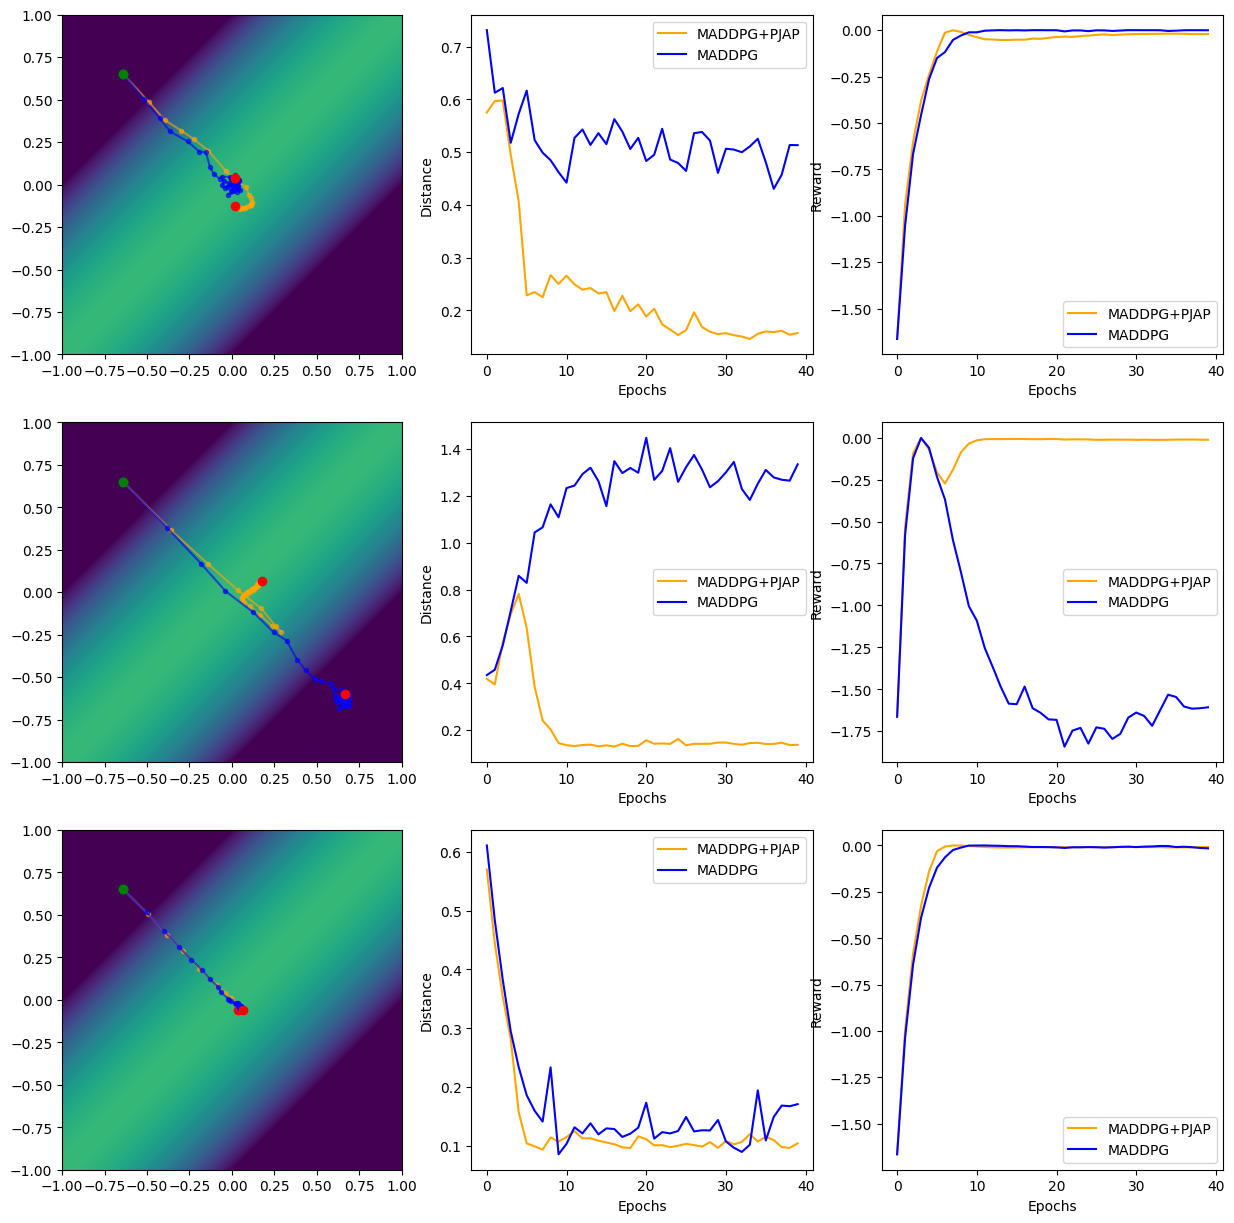

In [168]:
cols = ["orange","blue"]

# for optcentre

fig, ax = plt.subplots(len(datasets),3,figsize=(15,15))

for i in range(len(datasets)):

  (offline_maddpg_traj_rb, _, batches_rb, priority_record, distance_record_pjap) = action_pjap_data[str(i)]
  (acts_trajectory, (x_params, y_params), batches, distance_record) = action_data[str(i)]


  # plot trajectories before and after PJAP
  plot_surface_trajectory(q_fn, offline_maddpg_traj_rb,ax[i,0],cols[0])
  plot_surface_trajectory(q_fn,acts_trajectory,ax[i,0],cols[1])

  # plot distance measures
  rewards_pjap = q_fn(offline_maddpg_traj_rb[:, 0], offline_maddpg_traj_rb[:, 1])
  rewards = q_fn(acts_trajectory[:, 0], acts_trajectory[:, 1])

  # plot each of the distance records on one plot, where the x-axis is the epochs
  ax[i,1].plot(distance_record_pjap, label="MADDPG+PJAP",c=cols[0])
  ax[i,1].plot(distance_record, label="MADDPG",c=cols[1])
  ax[i,1].set_xlabel("Epochs")
  ax[i,1].set_ylabel("Distance")
  ax[i,1].legend()

  # plot each of the distance records on one plot, where the x-axis is the epochs
  ax[i,2].plot(rewards_pjap, label="MADDPG+PJAP",c=cols[0])
  ax[i,2].plot(rewards, label="MADDPG",c=cols[1])
  ax[i,2].set_xlabel("Epochs")
  ax[i,2].set_ylabel("Reward")
  ax[i,2].legend()

  # plt.gcf().set_size_inches(plot_size,plot_size)
plt.savefig("pjap_action.pdf",format="pdf")
plt.show()

### Twin peaks (Exact code used to generate plots in the paper)

First, we define the polynomial again.

In [169]:
a = 1
b = 4
c = 5
# cax = pl.axes([0.1, 0.2, 0.8, 0.6])
# define a polynomial reward function
def basic_q_fn(x, y):
    return -a*(x**2+y**2)-b*(x**2*y**2)+c*x*y

vector_q = np.vectorize(basic_q_fn)
q_fn = jax.jit(basic_q_fn)

optimum_positive = np.sqrt((c-2*a)/(2*b))

optima = np.array([[optimum_positive,-optimum_positive],[optimum_positive,-optimum_positive]])

/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 501`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:498: UserWarning: `sample_sequence_length` greater than `min_length_time_axis`, therefore overriding `min_length_time_axis`to be set to `sample_sequence_length`, as we need at least `sample_sequence_length` timesteps added to the buffer before we can sample.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 501`.This allows one to control exactly how many timesteps are stored in the buffer.Note that thi

29.795441389083862


/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 501`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:498: UserWarning: `sample_sequence_length` greater than `min_length_time_axis`, therefore overriding `min_length_time_axis`to be set to `sample_sequence_length`, as we need at least `sample_sequence_length` timesteps added to the buffer before we can sample.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 501`.This allows one to control exactly how many timesteps are stored in the buffer.Note that thi

61.092931032180786


/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 501`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:498: UserWarning: `sample_sequence_length` greater than `min_length_time_axis`, therefore overriding `min_length_time_axis`to be set to `sample_sequence_length`, as we need at least `sample_sequence_length` timesteps added to the buffer before we can sample.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 501`.This allows one to control exactly how many timesteps are stored in the buffer.Note that thi

91.52445960044861


/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 501`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:498: UserWarning: `sample_sequence_length` greater than `min_length_time_axis`, therefore overriding `min_length_time_axis`to be set to `sample_sequence_length`, as we need at least `sample_sequence_length` timesteps added to the buffer before we can sample.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/flashbax/buffers/trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 501`.This allows one to control exactly how many timesteps are stored in the buffer.Note that thi

124.44846868515015


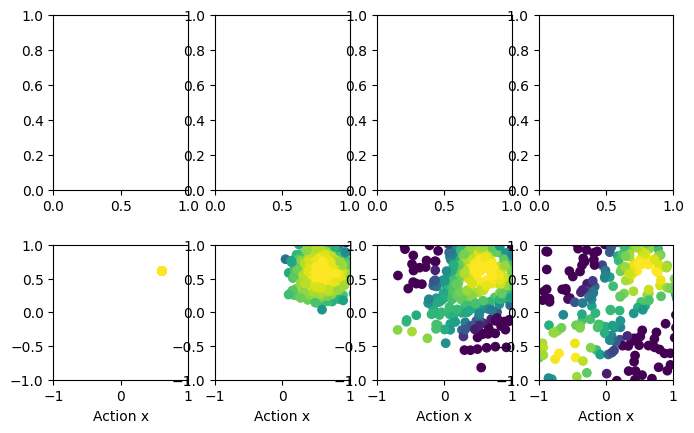

In [170]:
# Make uniform and spotlight datasets
dataset_size=500
key = jax.random.PRNGKey(1)

radii = [0,0.2,0.5,1]

datasets = []
for radius in radii:
  dataset, (x_hat, y_hat) = create_spotlight_dataset(q_fn,key,dataset_size, spotlight_center = jnp.asarray([optimum_positive,optimum_positive]), spotlight_radius = radius)
  datasets.append(dataset)

# Hyperparameters
lr = 2e-2
epochs = 100
batch_size=32
policy_init = (-0.5,0.5)

# visualise
fig,ax = plt.subplots(2,len(datasets),figsize=(2*len(datasets),5))

offline_data_twin_optcentre_lr = {}
offline_pjap_data_twin_optcentre_lr = {}

start = time.time()

for i, dataset in enumerate(datasets):

  # plot dataset itself
  plot_points(dataset,ax[1,i],q_fn)
  ax[1,i].set_xlabel("Action x")


  key = jax.random.PRNGKey(1)

  # Train offline
  acts_trajectory, (x_params, y_params), batches, distance_record = polygame_offline_maddpg_old(
        q_fn,
        key=key,
        dataset=dataset,
        batch_size=batch_size,
        epochs=epochs,
        lr=lr,
        policy_init=policy_init,
    )


  offline_data_twin_optcentre_lr[str(i)] = (acts_trajectory, (x_params, y_params), batches, distance_record)

  offline_maddpg_traj_rb, _, batches_rb, priority_record, distance_record = polygame_offline_maddpg_rb(
      q_fn,
      key,
      epochs=epochs,
      dataset=dataset,
      lr=lr,
      policy_init=policy_init,
      batch_size=batch_size,
      zeta=50,
  )

  offline_pjap_data_twin_optcentre_lr[str(i)] = (offline_maddpg_traj_rb, _, batches_rb, priority_record, distance_record)

  print(time.time()-start)

In [171]:
# for plotting a trajectory against a surface function
def plot_surface_trajectory(surface_fn: Callable, trajectory: jnp.ndarray, ax, col,step: int = 1, title: Optional[str] = "trajectory"):
    domain = jnp.linspace(-1, 1, 1000)
    ax.imshow(surface_fn(*jnp.meshgrid(domain, domain[::-1])), extent=(-1, 1, -1, 1),clim=(-1,0.5))

    # Trajectory
    # Extract x and y coordinates
    x = trajectory[:, 0]
    y = trajectory[:, 1]

    # Plot the trajectory
    ax.plot(x, y, '-w.',c=col, alpha=0.6)  # '-o' for lines with markers

    # Mark start and end points
    label1, = ax.plot(x[0], y[0], 'go',label="start")  # start point
    label2, = ax.plot(x[-1], y[-1], 'ro',label="end")  # end point

    ax.text(x[0]-0.03,y[0]+0.1, 'start',fontsize=7,c="white")
    ax.text(x[-1],y[-1]-0.2, 'end',fontsize=7)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_aspect('equal')

    return label1, label2

def plot_dist(distance_record_pjap,distance_record,cols,ax):
  # plot each of the distance records on one plot, where the x-axis is the epochs
  ax.plot(distance_record_pjap, label="MADDPG+PJAP",c=cols[0])
  ax.plot(distance_record, label="MADDPG",c=cols[1])
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Distance")
  # ax.legend()

def plot_rewards(rewards_pjap,rewards,cols,ax):
  # plot each of the distance records on one plot, where the x-axis is the epochs
  la, = ax.plot(rewards_pjap, label="MADDPG+PJAP",c=cols[0])
  lb, = ax.plot(rewards, label="MADDPG",c=cols[1])
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Reward")
  # ax.legend()
  return la, lb

def plot_points(points: jnp.ndarray, ax, alpha: float = 1.0, title: Optional[str] = None):
  """Plots a set of 3d points in 2d, with first two dimensions as x and y, and the third as color."""
  ax.scatter(points[:, 0], points[:, 1], c=points[:, 2], alpha=alpha)

  ax.set_xlim(-1.1, 1.1)
  ax.set_ylim(-1.1, 1.1)

  ax.set_xlabel('Action x')
  ax.set_ylabel('Action y')
  ax.set_aspect('equal')

<ipython-input-171-92e0d9c797bf>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-w." (-> color='w'). The keyword argument will take precedence.
  ax.plot(x, y, '-w.',c=col, alpha=0.6)  # '-o' for lines with markers
<ipython-input-171-92e0d9c797bf>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-w." (-> color='w'). The keyword argument will take precedence.
  ax.plot(x, y, '-w.',c=col, alpha=0.6)  # '-o' for lines with markers


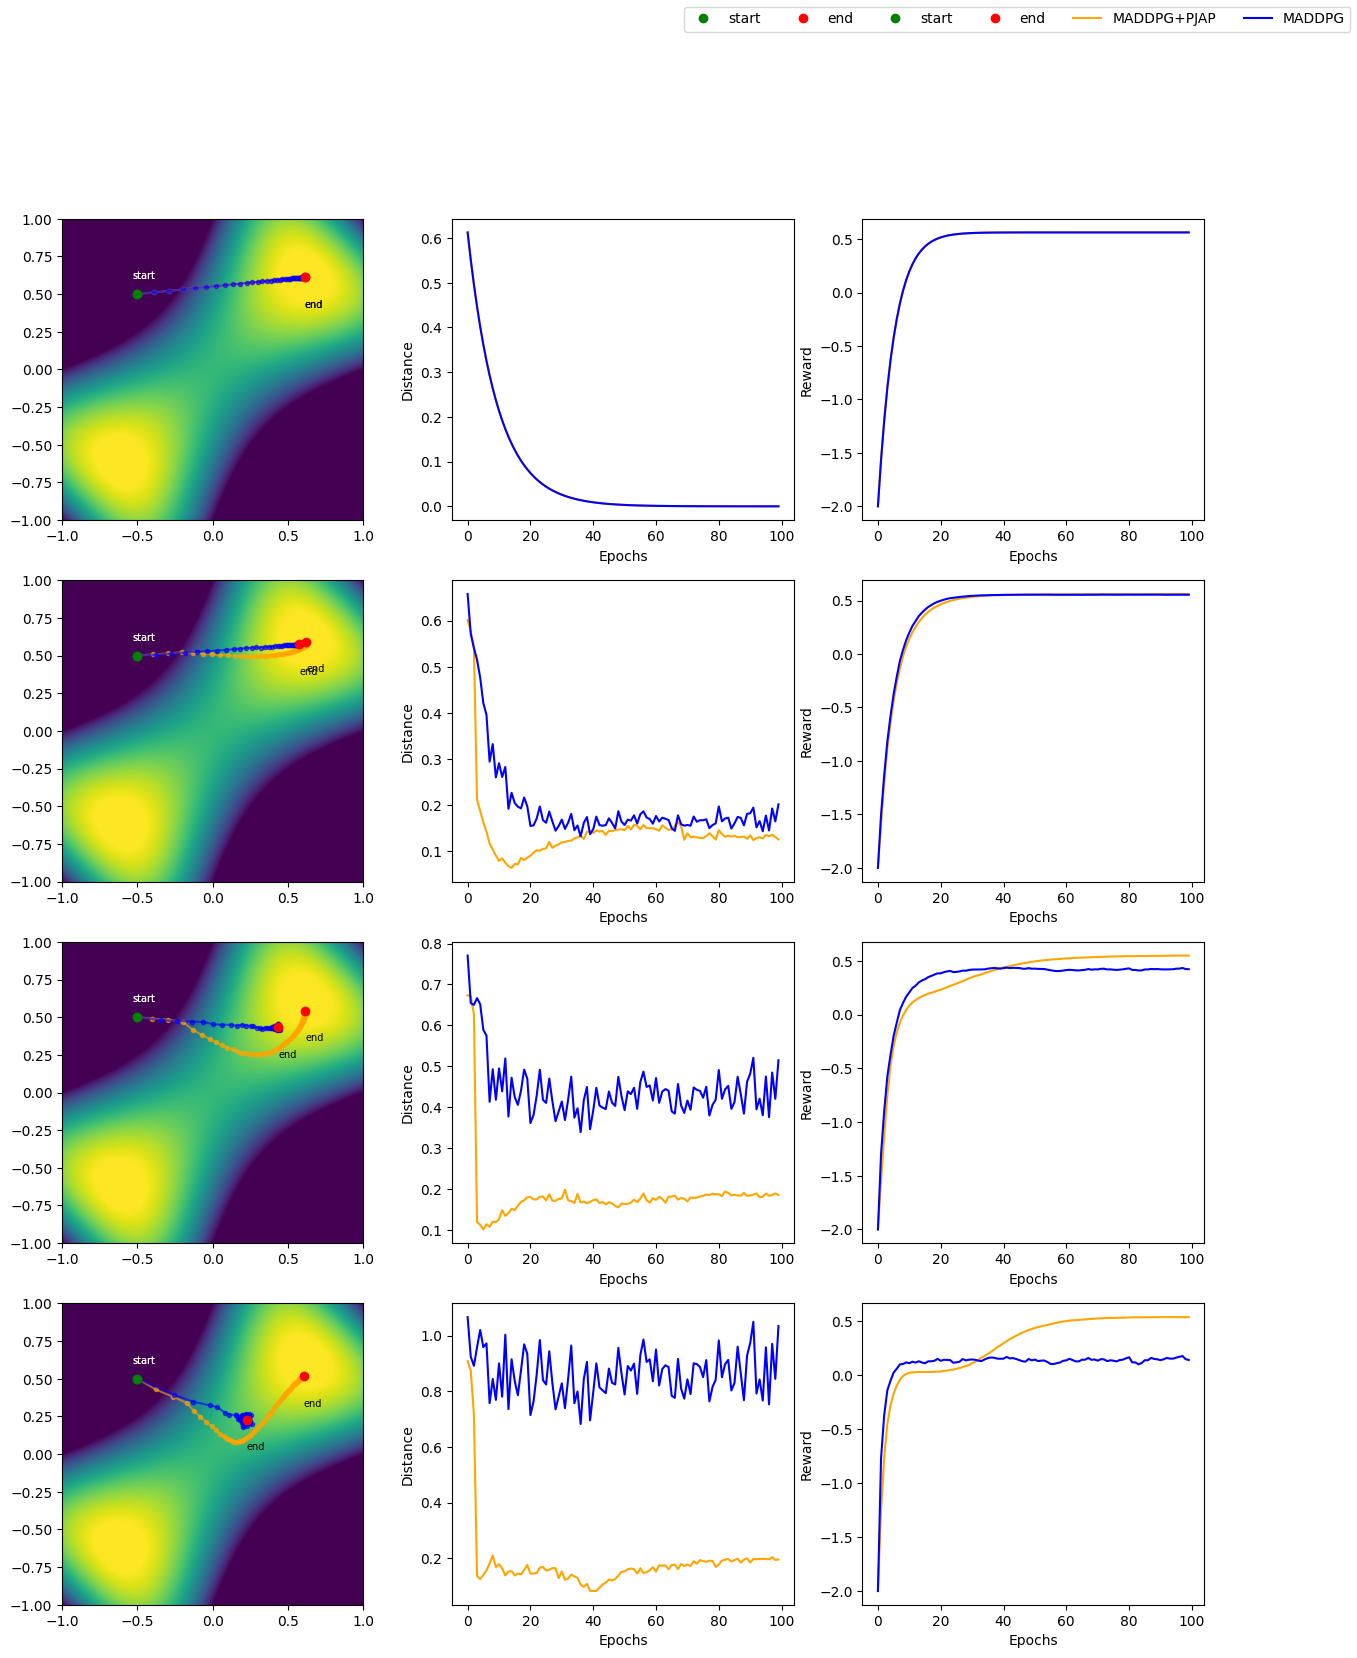

In [172]:
cols = ["orange","blue"]

# for optcentre

fig, ax = plt.subplots(len(datasets),3,figsize=(15,18))

for i in range(len(datasets)):

  (offline_maddpg_traj_rb, _, batches_rb, priority_record, distance_record_pjap) = offline_pjap_data_twin_optcentre_lr[str(i)]
  (acts_trajectory, (x_params, y_params), batches, distance_record) = offline_data_twin_optcentre_lr[str(i)]


  # plot trajectories before and after PJAP
  plot_surface_trajectory(q_fn, offline_maddpg_traj_rb,ax[i,0],cols[0])
  plot_surface_trajectory(q_fn,acts_trajectory,ax[i,0],cols[1])

  # plot distance measures
  rewards_pjap = q_fn(offline_maddpg_traj_rb[:, 0], offline_maddpg_traj_rb[:, 1])
  rewards = q_fn(acts_trajectory[:, 0], acts_trajectory[:, 1])

  # plot each of the distance records on one plot, where the x-axis is the epochs
  plot_dist(distance_record_pjap,distance_record,cols,ax[i,1])

  # plot each of the distance records on one plot, where the x-axis is the epochs
  la,lb = plot_rewards(rewards_pjap,rewards,cols,ax[i,2])

  # plt.gcf().set_size_inches(plot_size,plot_size)

# fig.subplots_adjust(top=0.8)
# legend_ax = fig.add_axes([0.05, 0.7, 0.85, 0.15])
# legend_ax.legend([la,lb], ["MADDPG","MADDPG+PJAP"])

lines_labels = [ax.get_legend_handles_labels() for ax in [ax[0,0],ax[0,2]]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,ncols=6)
plt.savefig("pjap_twin_opt.pdf",format="pdf")
plt.show()

<ipython-input-171-92e0d9c797bf>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-w." (-> color='w'). The keyword argument will take precedence.
  ax.plot(x, y, '-w.',c=col, alpha=0.6)  # '-o' for lines with markers


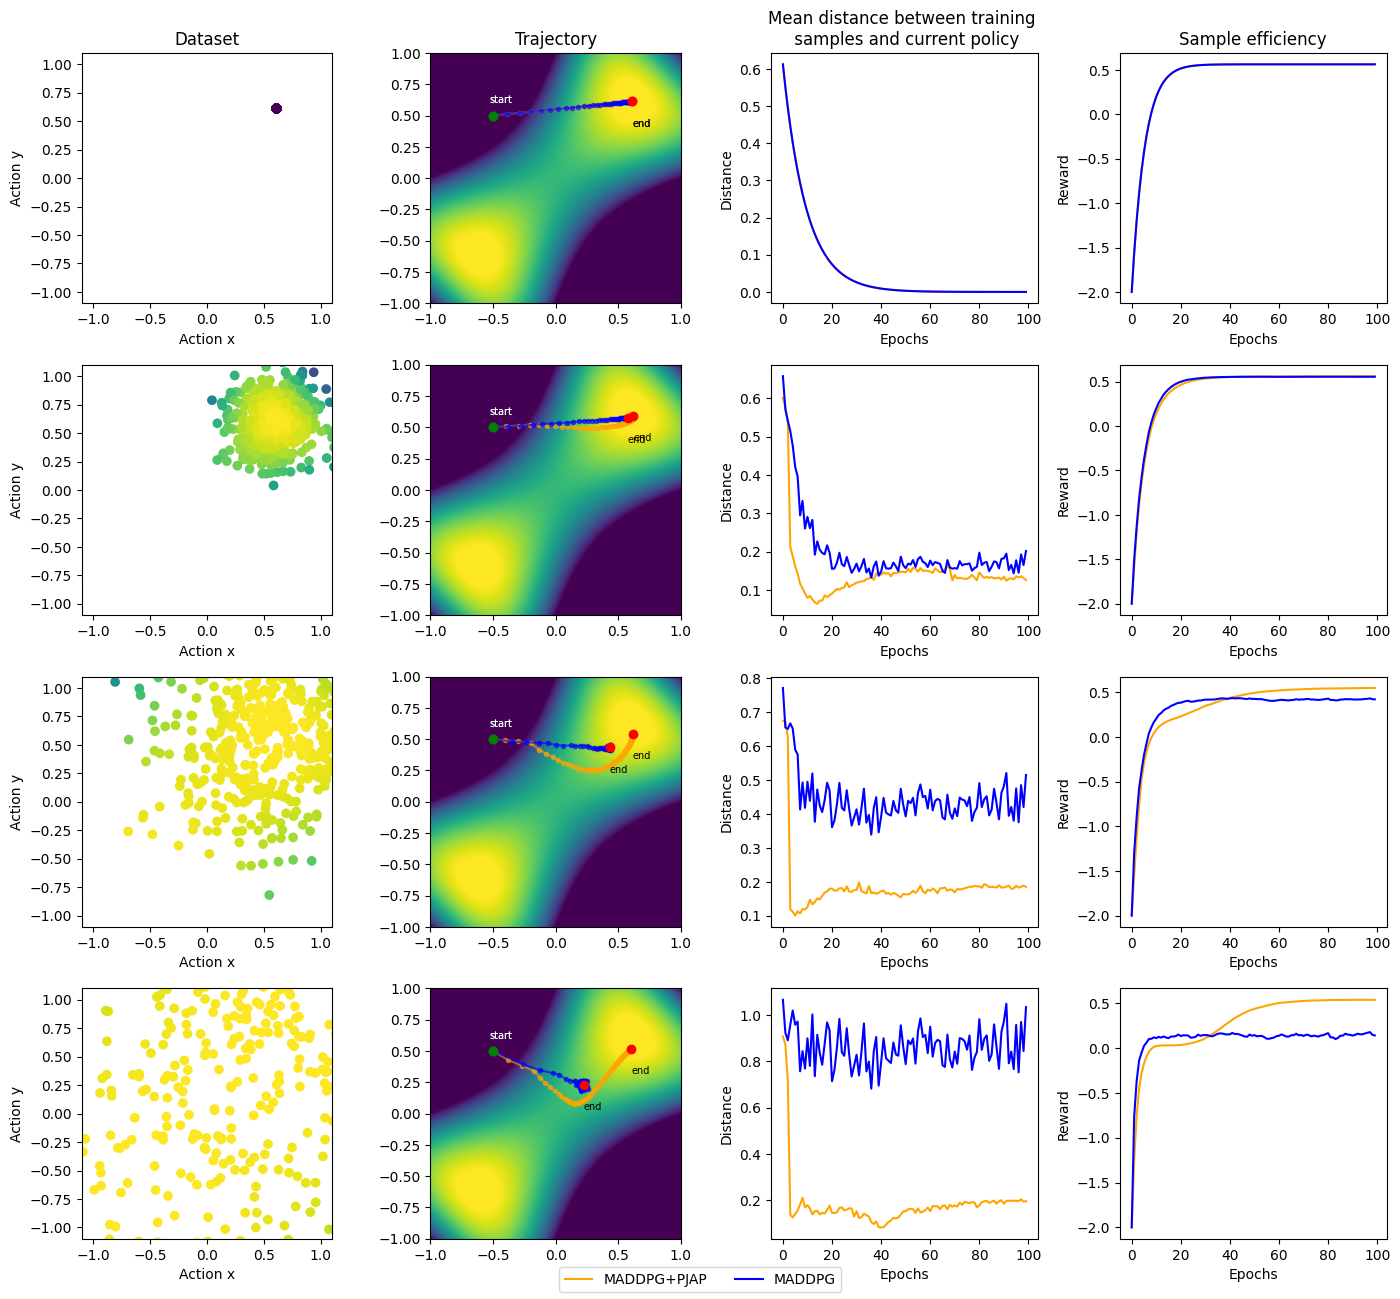

In [173]:
cols = ["orange","blue"]

# for optcentre

fig, ax = plt.subplots(len(datasets),4,figsize=(14,13))


for i in range(len(datasets)):

  plot_points(datasets[i],ax[i,0])

  (offline_maddpg_traj_rb, _, batches_rb, priority_record, distance_record_pjap) = offline_pjap_data_twin_optcentre_lr[str(i)]
  (acts_trajectory, (x_params, y_params), batches, distance_record) = offline_data_twin_optcentre_lr[str(i)]


  # plot trajectories before and after PJAP
  plot_surface_trajectory(q_fn, offline_maddpg_traj_rb,ax[i,1],cols[0])
  plot_surface_trajectory(q_fn,acts_trajectory,ax[i,1],cols[1])

  # plot distance measures
  rewards_pjap = q_fn(offline_maddpg_traj_rb[:, 0], offline_maddpg_traj_rb[:, 1])
  rewards = q_fn(acts_trajectory[:, 0], acts_trajectory[:, 1])

  # plot each of the distance records on one plot, where the x-axis is the epochs
  plot_dist(distance_record_pjap,distance_record,cols,ax[i,2])

  # plot each of the distance records on one plot, where the x-axis is the epochs
  plot_rewards(rewards_pjap,rewards,cols,ax[i,3])

  # plt.gcf().set_size_inches(plot_size,plot_size)
ax[0,0].set_title("Dataset")
ax[0,1].set_title("Trajectory")
ax[0,2].set_title("Mean distance between training \n samples and current policy")
ax[0,3].set_title("Sample efficiency")
lines_labels = [ax.get_legend_handles_labels() for ax in [ax[0,3]]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,ncols=2,loc='lower center')
fig.tight_layout(pad=1.0)
plt.savefig("pjap_twin_opt_withscatter.pdf",format="pdf",bbox_inches='tight')
plt.show()